# Proyecto Grupo 5 - Análisis Musical en Spotify

# Librerias y Config
¡¡Se requiere ajustar una variable en la sección de Drive!! \
¡¡Se requiere interacción en la sección de Kaggle!! \


In [3]:
import os
import shutil
import typing
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [5]:
# definir excepción para detener ejecución de celda
class StopExecution(Exception):
    # render reason
    def _render_traceback_(self):
        return 'Detenido por condición de celda'

## Config de colab

In [6]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print(f"IN_COLAB: {IN_COLAB}")

IN_COLAB: False


In [7]:
proyect_path = './'
data_folder = proyect_path + 'data/'
if IN_COLAB:
  !mkdir -p $data_folder
  !ls $data_folder
else:
  !mkdir data

Ya existe el subdirectorio o el archivo data.


## Config de Drive

Con Google Drive conseguiremos `merge_data.csv`, dado que el procesamiento de `spotify.sqlite` es demasiado costoso para ser ejecutado en google colab. \
[La carpeta del proyecto en GDrive](https://drive.google.com/drive/u/1/folders/1RcMfeIuqRVhP1A-0YAi0b43ip3i1ro_s) (se debera crear un acceso directo a esta carpeta. La variable `Path_drive` definida a continuación debera apuntar a esa dirección)

Solo se puede importar su carpeta de drive, asi que no hay una solucion universal y que de la libertad de guardar la carpeta donde sea.


In [38]:
# @title Carpeta de Drive del proyecto { vertical-output: true }
Path_drive = "MyDrive/La Mineria mata el alma y la envenena/" # @param {type:"string"}
print(f"Path_drive: {Path_drive}")

Path_drive: MyDrive/La Mineria mata el alma y la envenena/


c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

In [39]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  src = "/content/drive/" + Path_drive + "data/"
  dst = data_folder
  print(f"copiando archivos desde {src} a {dst}")
  shutil.copytree(src, dst, dirs_exist_ok=True)
  del src, dst
  drive.flush_and_unmount()

c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

## Config de kaggle
¡¡Aqui se requiere interacción para subir un archivo!!

In [40]:
if IN_COLAB:
  from google.colab import files
  if not os.path.exists(proyect_path + "kaggle.json"):
    print("Suba su archivo kaggle.json")
    upload = files.upload()
  # crear directorio en ~ si no existe
  !mkdir -p ~/.kaggle
  # copiar archivo al directorio de kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

else: # asumiendo que kaggle.json esta en el directorio del proyecto
  import os
  import shutil

  # archivo y directorio de destino
  src_path = f"{proyect_path}kaggle.json"
  dst_path = os.path.expanduser("~/.kaggle/")

  # Crear el directorio si no existe
  if not os.path.exists(dst_path):
      os.makedirs(dst_path)

  # Copiar el archivo
  try:
    shutil.copy(src_path, dst_path)
  except Exception as e:
    print(e)
  # Dar permisos
  os.chmod(dst_path + "kaggle.json", 600)

  # clean up
  del src_path, dst_path

# probar si funciona la api
!kaggle datasets list

[Errno 13] Permission denied: 'C:\\Users\\Nico/.kaggle/kaggle.json'


c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

# spotify.sqlite

`spotify.sqlite` es el archivo con el que partimos este proyecto, obtenido de [los siguientes datos de kaggle](https://www.kaggle.com/datasets/maltegrosse/8-m-spotify-tracks-genre-audio-features). Contiene millones de canciones junto al analisis de caracteristicas que provee la api de spotify.

🚧 El procesamiento consume mucha ram, asi que puede fallar si no hay suficiente. 🚧

La ejecucion esta desactivada por defecto, pero [en github](https://github.com/DamnXitri/spotify-data-mining) estará subido con los resultados de ejecución corridos localmente.

In [41]:
PROCESS_SQLITE = True

c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

## Descarga de datos

In [42]:
if not PROCESS_SQLITE: raise StopExecution

# descargar el dataset si no existe
if not os.path.exists(data_folder + 'spotify.sqlite'):
  !kaggle datasets download -d maltegrosse/8-m-spotify-tracks-genre-audio-features -p $data_folder --unzip

c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

## Cargando datos

Estos se encuentran contenidos en una BDD `spotify.sqlite`, la cual tendremos en una carpeta `data`.

In [43]:
if not PROCESS_SQLITE: raise StopExecution
import sqlite3

# funcion para cargar las tablas de la base de datos en un diccionario de dataframes
def load_data(tables):
  # conexion a la base de datos
  conn = sqlite3.connect(
    database= data_folder + 'spotify.sqlite'
  )
  # para que no haya problemas con los caracteres especiales
  conn.text_factory = lambda b: b.decode(encoding = 'utf-8', errors = 'ignore')

  # diccionario de dataframes
  dataframes : typing.Dict[str, pd.DataFrame] = {}

  # cargar cada tabla en un dataframe
  for table in tables:
    dataframes[table] = pd.read_sql_query(
      sql = f"SELECT * FROM {table}",
      con = conn
    )

  # cerrar la conexion a la base de datos
  conn.close()

  return dataframes

c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

In [44]:
if not PROCESS_SQLITE: raise StopExecution
# lista de tablas de la base de datos
tables = [
  "r_albums_artists",
  "r_albums_tracks",
  "r_artist_genre",
  "r_track_artist",
  "genres",
  "albums",
  "artists",
  "audio_features",
  "tracks",
]

# ejecutar la funcion
dataframes : typing.Dict[str, pd.DataFrame] = load_data(tables)
[
  tracks, artists, albums, genres, audio_features,
  r_albums_artists, r_albums_tracks, r_artist_genre, r_track_artist
] = [
  dataframes.get('tracks'), dataframes.get('artists'), dataframes.get('albums'), dataframes.get('genres'), dataframes.get('audio_features') ,
  dataframes.get('r_albums_artists'), dataframes.get('r_albums_tracks'), dataframes.get('r_artist_genre'), dataframes.get('r_track_artist')
]
# ver las tablas cargadas
dataframes.keys()

c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)  # noqa
c:\Users\Nico\Git\spotify-data-mining\.env\Lib\site-packages\jupyter_client\session.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ret

## Formato de las tablas

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
info_df = pd.DataFrame()
info_df['tabla'] = dataframes.keys()
info_df['filas'] = [dataframes[i].shape[0] for i in dataframes.keys()]
info_df['columnas'] = [dataframes[i].shape[1] for i in dataframes.keys()]
info_df['nombre_columnas'] = [list(dataframes[i].columns) for i in dataframes.keys()]

info_df.set_index('tabla', inplace=True)
info_df

,filas,columnas,nombre_columnas
tabla,,,
r_albums_artists,921486,2,"[album_id, artist_id]"
r_albums_tracks,9900173,2,"[album_id, track_id]"
r_artist_genre,487386,2,"[genre_id, artist_id]"
r_track_artist,11840402,2,"[track_id, artist_id]"
genres,5489,1,[id]
albums,4820754,6,"[id, name, album_group, album_type, release_date, popularity]"
artists,1066031,4,"[name, id, popularity, followers]"
audio_features,8740043,15,"[id, acousticness, analysis_url, danceability, duration, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]"
tracks,8741672,10,"[id, disc_number, duration, explicit, audio_feature_id, name, preview_url, track_number, popularity, is_playable]"


## Estadisticas y exploración inicial

Las tablas `r_albums_artists`, `r_albums_tracks`, `r_artist_genre` y `genres` solamente contienen ids, por lo que no contienen estadisticas interesantes

### albums

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
albums.head()

,id,name,album_group,album_type,release_date,popularity
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",,album,954633600000,0
1,4JYUDRtPZuVNi7FAnbHyux,"Flava in Ya Ear Remix (feat. Notorious B.I.G., L.L. Cool J, Busta Rhymes, Rampage)",,single,757382400000,0
2,6YjKAkDYmlasMqYw73iB0w,Bitch Please II,,album,959040000000,0
3,2YlvHjDb4Tyxl4A1IcDhAe,Just Dippin',,compilation,1104537600000,0
4,3UOuBNEin5peSRqdzvlnWM,Still D.R.E.,,album,942710400000,0


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
albums.shape

(4820754, 6)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
albums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820754 entries, 0 to 4820753
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   id            object
 1   name          object
 2   album_group   object
 3   album_type    object
 4   release_date  int64 
 5   popularity    int64 
dtypes: int64(2), object(4)
memory usage: 220.7+ MB


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
albums['album_type'] = albums['album_type'].astype('category')
albums.describe()

,release_date,popularity
count,4820754.0000,4820754.0000
mean,1222681215510.4368,2.1524
std,469358868052.1105,8.0736
min,-62135769600000.0000,0.0000
25%,1139961600000.0000,0.0000
50%,1311033600000.0000,0.0000
75%,1414713600000.0000,0.0000
max,1644537600000.0000,100.0000


En base a las celdas anteriores, consideramos:

- Formalizar `release_date`, estan en formato timestamp unix, por lo que seria conveniente tener esa informacion como fecha. \
  Ademas debemos tener cuidado con los timestamps negativos, los que nos pueden traer problemas (algunos van al año 0)
- Analizar si la popularidad del album es importante, pues 75% de sus valores es 0 en un rango de 0 a 100


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
albums['album_type'].value_counts()

album_type
album          3612835
compilation     766770
single          441149
Name: count, dtype: int64

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
albums['album_group'].value_counts()

album_group
    4820754
Name: count, dtype: int64

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
(albums['album_group'] == '').value_counts()

album_group
True    4820754
Name: count, dtype: int64

En base a las celdas anteriores, consideramos:

- `album_group`, que solo contiene strings vacios, es candidato a eliminar.
  

### artists

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
artists.head()

,name,id,popularity,followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665
1,Erick Sermon,2VX0o9LDIVmKIgpnwdJpOJ,54,142007
2,J. Ro,3iBOsmwGzRKyR0vs2I61xP,45,158
3,Tash,22qf8cJRzBjIWb2Jc4JeOr,48,3421
4,Craig Mack,4akj4uteQQrrGxhX9Rjuyf,55,161966


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
artists.shape

(1066031, 4)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066031 entries, 0 to 1066030
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   name        1066031 non-null  object
 1   id          1066031 non-null  object
 2   popularity  1066031 non-null  int64 
 3   followers   1066031 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.5+ MB


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
artists.describe()

,popularity,followers
count,1066031.0000,1066031.0000
mean,5.4179,7012.3596
std,11.9438,208718.4287
min,0.0000,0.0000
25%,0.0000,0.0000
50%,0.0000,0.0000
75%,3.0000,101.0000
max,98.0000,78503098.0000


Aqui no consideramos modificar los datos. Pero hay que considerar un analisis mas en profundidad de las columnas de popularidad y seguidores.

### tracks

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks.head()

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
0,1dizvxctg9dHEyaYTFufVi,1,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),,12,0,NaN
1,2g8HN35AnVGIk7B8yMucww,1,252746,1,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,https://p.scdn.co/mp3-preview/770e023eb0318270ecc5caa018d758e5e0844de9?cid=cde021ca5d3e42a8bd440f1004a562dc,13,77,NaN
2,49pnyECzcMGCKAqxfTB4JZ,3,315080,0,49pnyECzcMGCKAqxfTB4JZ,"You Were Born - Early Version Of ""One Of The Three"" / Outtake",,6,8,1.0000
3,4E5IFAXCob6QqZaJMTw5YN,1,240800,1,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,https://p.scdn.co/mp3-preview/f3b556ced9657f8987d2c981014205244daf4540?cid=cde021ca5d3e42a8bd440f1004a562dc,2,70,NaN
4,1gSt2UlC7mtRtJIc5zqKWn,2,203666,0,1gSt2UlC7mtRtJIc5zqKWn,"It's Hard To Say ""I Do"", When I Don't",,2,50,NaN


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks.shape

(8741672, 10)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741672 entries, 0 to 8741671
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                object 
 1   disc_number       int64  
 2   duration          int64  
 3   explicit          int64  
 4   audio_feature_id  object 
 5   name              object 
 6   preview_url       object 
 7   track_number      int64  
 8   popularity        int64  
 9   is_playable       float64
dtypes: float64(1), int64(5), object(4)
memory usage: 666.9+ MB


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks.describe()

,disc_number,duration,explicit,track_number,popularity,is_playable
count,8741672.0000,8741672.0000,8741672.0000,8741672.0000,8741672.0000,413800.0000
mean,1.1375,236968.7389,0.0668,10.9318,6.1183,0.8754
std,0.9959,159688.6600,0.2497,22.7224,10.5798,0.3303
min,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
25%,1.0000,169200.0000,0.0000,4.0000,0.0000,1.0000
50%,1.0000,216160.0000,0.0000,7.0000,1.0000,1.0000
75%,1.0000,273887.0000,0.0000,12.0000,8.0000,1.0000
max,63.0000,19672058.0000,1.0000,1522.0000,100.0000,1.0000


A partir de las celdas anteriores, consideramos:

- `disc_number` es candidato a eliminar, pues tiene poca varianza y algunos outliers.
- Analizar si `track_number` puede ser una columna util o no. Parece tener outliers (ver `max`).
- `is_playable` es candidato a eliminar, pues su count indica que muchos de sus valores son nulos.


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['disc_number'].value_counts()

disc_number
1     8204349
2      348328
3       80298
4       38099
5       20324
       ...   
63          6
57          5
59          5
62          4
58          3
Name: count, Length: 63, dtype: int64

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['disc_number'].max()

63

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['disc_number'].var()

0.9917664238559349

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['track_number'].value_counts()

track_number
1       806135
2       680726
3       652969
4       632889
5       603712
         ...  
1132         1
1129         1
1114         1
1121         1
999          1
Name: count, Length: 1522, dtype: int64

OPAAA, que paso ahi?
investiguemos 😎

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['track_number'].max()

1522

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks[tracks['track_number'] >= 1000].sample(5)

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
3148822,5uvORUyZBqZcWLnxUZLRuD,1,124600,0,5uvORUyZBqZcWLnxUZLRuD,Chapter 1227 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/9d424e82eb1c35e7569f8e1bfd395b33dc74758c?cid=cd552680dec84110b29ddf95d645cbe8,1227,0,NaN
3149043,5e718GzJ9KEEMndiC6qRod,1,125100,0,5e718GzJ9KEEMndiC6qRod,Chapter 1437 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/7f8b5c7ff7a429be54e029386313b31122114896?cid=cd552680dec84110b29ddf95d645cbe8,1437,0,NaN
2972489,4kDXzhk3CadHVzdnMcpeXC,1,140500,0,4kDXzhk3CadHVzdnMcpeXC,Chapter 1056 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/f00045ee8983e7ed725f62207d45c0f96e9b5def?cid=cd552680dec84110b29ddf95d645cbe8,1056,0,NaN
3240565,2VYDCrx9zWWeK4sD5tsSMA,1,122700,0,2VYDCrx9zWWeK4sD5tsSMA,Chapter 1343 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/06dc71d94d816d0a504ae278947ef28d041db716?cid=cd552680dec84110b29ddf95d645cbe8,1343,0,NaN
8286136,05N3jHNi0zaNSauqh1LDNh,1,129300,0,05N3jHNi0zaNSauqh1LDNh,Chapter 1360 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/c426bd83fabf0ba864ca1674b468d6cac801346f?cid=cd552680dec84110b29ddf95d645cbe8,1360,0,NaN


Curioso, estas canciones estan relacionadas y tienen su numero de **_Chapter_** como `track_number`, esto nos genera una serie de outliers que posiblemente van de track number 1 a 1522. Extendamos la busqueda.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

# obtenemos todos los tracks del album que contiene el track con el numero mas alto
r_albums_tracks[
  r_albums_tracks['album_id'] == r_albums_tracks[
    # album que tiene el track con el numero mas alto
    r_albums_tracks['track_id'] == tracks[
      # track con el numero mas alto
      tracks['track_number'] == tracks['track_number'].max()
    ]['id'].values[0]
  ]['album_id'].values[0]
].shape

(1522, 2)

Exactamente lo que pensabamos, tenemos nuestro primer outlier, hay audiolibros entre nuestros albums. Utilizemos `track_number` como filtro para ver si encontramos otros.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks[tracks['track_number'] >= 500].sample(5)

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
3148666,1iwKo25Dpk6A4phryZnnl1,1,155800,0,1iwKo25Dpk6A4phryZnnl1,Chapter 1072 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/6d8e92a1133b619b3562755ba80adcde8c3ca83b?cid=cd552680dec84110b29ddf95d645cbe8,1072,0,NaN
8048940,1Rvw8BWxt80NxzzZwmITGp,1,155128,0,1Rvw8BWxt80NxzzZwmITGp,Psalms 059,,538,0,NaN
8503001,0GR4sgl6MWLFBnC5NvGGDU,1,147343,0,0GR4sgl6MWLFBnC5NvGGDU,Micah 03,https://p.scdn.co/mp3-preview/f44c48592b95e74560dbc73c4ad4c1e3527af160?cid=cd552680dec84110b29ddf95d645cbe8,897,7,NaN
3155316,1L1IsNwdikVxgtRh80bBtb,1,190450,0,1L1IsNwdikVxgtRh80bBtb,Proverbs 21,https://p.scdn.co/mp3-preview/0d09de3f6d575e9bc961598a379780003e5c0d50?cid=cd552680dec84110b29ddf95d645cbe8,650,14,NaN
3417381,5tzTljNaldxxtBYRoziRAM,1,121300,0,5tzTljNaldxxtBYRoziRAM,Chapter 1353 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/1ae2ab8b151a29d70d2801bd579da4cda9686f99?cid=cd552680dec84110b29ddf95d645cbe8,1353,0,NaN


En efecto, Aparecen más cosas de ese estilo, pero ademas comenzamos a encontrar narraciones de la biblia (?), efectos de sonido y varias versiones de canciones de musica clasica (posiblemente de albumes recopilatorios). \
En base a esto podemos definir que `track_number` nos puede servir como filtro a todos estos datos que no nos sean utiles y que quizas podemos excluir los albumes recopilatorios de los datos. \
Finalmente, hay que decidir donde pondremos nuestro limite a considerar y si excluimos los albumes recopilatorios de los datos.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['is_playable'].value_counts()

is_playable
1.0000    362237
0.0000     51563
Name: count, dtype: int64

Ya habiamos visto que a esta columna le faltaban muchos datos, comprobemos cuantos son nulos.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks[tracks['is_playable'].isna()].shape

(8327872, 10)

Hay muchos nulos en esta columna!!! Claramente es eliminable.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['explicit'].value_counts()

explicit
0    8157738
1     583934
Name: count, dtype: int64

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks[tracks['explicit'].isna()].shape

(0, 10)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
tracks['duration'].value_counts()

duration
240000    4817
180000    3807
192000    3742
210000    3034
216000    2745
          ... 
453684       1
466432       1
320482       1
369663       1
373341       1
Name: count, Length: 521764, dtype: int64

La duracion tambien evidencia presencia de algunos outliers, sin embargo, conviene excluir a los relatos y albumes recopilatorios del analisis y verificar nuevamente.

### audio_features

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
audio_features.head()

,id,acousticness,analysis_url,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P,0.8930,219160,0.5140,0.0000,11,0.0596,-5.0800,1,0.2830,95.8480,4,0.7870
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,https://api.spotify.com/v1/audio-analysis/4JYUDRtPZuVNi7FAnbHyux,0.5200,302013,0.8470,0.0000,9,0.3250,-5.3000,1,0.4270,177.3710,4,0.7990
2,6YjKAkDYmlasMqYw73iB0w,0.0783,https://api.spotify.com/v1/audio-analysis/6YjKAkDYmlasMqYw73iB0w,0.9180,288200,0.5860,0.0000,1,0.1450,-2.8900,1,0.1330,95.5170,4,0.7790
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,https://api.spotify.com/v1/audio-analysis/2YlvHjDb4Tyxl4A1IcDhAe,0.8770,243013,0.6810,0.0000,1,0.1190,-6.2770,0,0.2590,94.8350,4,0.8390
4,3UOuBNEin5peSRqdzvlnWM,0.1700,https://api.spotify.com/v1/audio-analysis/3UOuBNEin5peSRqdzvlnWM,0.8140,270667,0.7810,0.0005,11,0.0520,-3.3300,1,0.2330,93.4450,4,0.5360


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
audio_features.shape

(8740043, 15)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740043 entries, 0 to 8740042
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                object 
 1   acousticness      float64
 2   analysis_url      object 
 3   danceability      float64
 4   duration          int64  
 5   energy            float64
 6   instrumentalness  float64
 7   key               int64  
 8   liveness          float64
 9   loudness          float64
 10  mode              int64  
 11  speechiness       float64
 12  tempo             float64
 13  time_signature    int64  
 14  valence           float64
dtypes: float64(9), int64(4), object(2)
memory usage: 1000.2+ MB


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
audio_features.describe()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000
mean,0.4190,0.5330,236811.4380,0.5476,0.2558,5.2416,0.2066,-10.7912,0.6604,0.0963,118.6613,3.8404,0.4804
std,0.3757,0.1916,154643.2409,0.2818,0.3683,3.5429,0.1818,6.2803,0.4736,0.1407,31.0415,0.5668,0.2801
min,0.0000,0.0000,1000.0000,0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0330,0.4000,169227.0000,0.3170,0.0000,2.0000,0.0963,-13.5210,0.0000,0.0359,95.2210,4.0000,0.2390
50%,0.3310,0.5490,216160.0000,0.5710,0.0018,5.0000,0.1300,-9.1360,1.0000,0.0473,119.0980,4.0000,0.4750
75%,0.8110,0.6790,273893.0000,0.7910,0.6330,8.0000,0.2640,-6.3640,1.0000,0.0833,137.5130,4.0000,0.7150
max,0.9960,1.0000,6072187.0000,1.0000,1.0000,11.0000,1.0000,6.2750,1.0000,0.9740,249.9870,5.0000,1.0000


Aqui solo eliminaremos `analysis_url` (no nos sirve sin un token), pues es la tabla con la informacion de mayor interes.

### genres

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
genres.head()

,id
0,detroit hip hop
1,g funk
2,gangster rap
3,hardcore hip hop
4,hip hop


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
genres.shape

(5489, 1)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5489 non-null   object
dtypes: object(1)
memory usage: 43.0+ KB


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
genres.value_counts()

id                    
21st century classical    1
norwegian blues           1
norwegian folk            1
norwegian experimental    1
norwegian doom metal      1
                         ..
folk-pop                  1
folk siciliana            1
folk rock italiano        1
folk rock                 1
zydeco                    1
Name: count, Length: 5489, dtype: int64

Esta tabla va relacionada al artista, no a las canciones o albumes, por lo que hay que considerar si es realmente util o no.

## Eliminar y modificar columnas

### albums

Inicialmente, modificaremos `release_date` para que sea en formato de fecha y no timestamp, luego eliminamos `album_group` debido a que todos son valores vacios.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

# debido a limitaciones en los timestamps de pandas, utilizamos la clase datetime de python (la columna será de tipo object para pandas)
# no tan fun fact: pd.Timestamp.min es el 1 de enero de 1677 :(

# Para rematar, fromtimestamp() no acepta fechas negativas, por lo que tenemos que hacer un workaround con timedelta

# funcion para convertir un timestamp a una fecha
def convert_timestamp_to_date(timestamp):
  try:
    # pasamos el timestamp a dias y luego a fecha
    return (datetime.datetime.fromtimestamp(0) + datetime.timedelta(days = timestamp / 1000 / 60 / 60 / 24)).date()
  # existe un limite para las fechas negativas, lo que nos da un error de OverflowError
  except OverflowError:
    # si el timestamp es positivo, devolvemos la fecha maxima
    if timestamp > 0:
      return datetime.datetime.max.date()
    # si el timestamp es negativo, devolvemos la fecha minima
    else:
      return datetime.datetime.min.date()

# pasar release_date de timestamp a datetime
albums['album_release_date'] = albums['release_date'].apply(
  lambda x: convert_timestamp_to_date(x)
)
albums['album_release_year'] = albums['album_release_date'].apply(
  lambda x: x.year
)
albums['album_release_month'] = albums['album_release_date'].apply(
  lambda x: x.month
)
# OJO: probablemente no sea muy preciso
albums['album_release_day'] = albums['album_release_date'].apply(
  lambda x: x.day
)

albums.drop(columns=[
  'album_group', 'release_date',
], inplace=True)
albums.rename(columns={
  'id': 'album_id',
  'name': 'album_name',
  'popularity': 'album_popularity',
}, inplace=True)
albums.head()

,album_id,album_name,album_type,album_popularity,album_release_date,album_release_year,album_release_month,album_release_day
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",album,0,2000-04-01,2000,4,1
1,4JYUDRtPZuVNi7FAnbHyux,"Flava in Ya Ear Remix (feat. Notorious B.I.G., L.L. Cool J, Busta Rhymes, Rampage)",single,0,1993-12-31,1993,12,31
2,6YjKAkDYmlasMqYw73iB0w,Bitch Please II,album,0,2000-05-22,2000,5,22
3,2YlvHjDb4Tyxl4A1IcDhAe,Just Dippin',compilation,0,2004-12-31,2004,12,31
4,3UOuBNEin5peSRqdzvlnWM,Still D.R.E.,album,0,1999-11-15,1999,11,15


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
albums.describe()

,album_popularity,album_release_year,album_release_month,album_release_day
count,4820754.0000,4820754.0000,4820754.0000,4820754.0000
mean,2.1524,2008.1250,7.8078,19.8516
std,8.0736,14.9416,3.7384,10.1188
min,0.0000,1.0000,1.0000,1.0000
25%,0.0000,2006.0000,5.0000,11.0000
50%,0.0000,2011.0000,8.0000,21.0000
75%,0.0000,2014.0000,12.0000,31.0000
max,100.0000,2022.0000,12.0000,31.0000


### artists

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

artists.rename(columns={
  'id': 'artist_id',
  'name': 'artist_name',
  'popularity': 'artist_popularity',
  'followers': 'artist_followers',
}, inplace=True)
artists.head()

,artist_name,artist_id,artist_popularity,artist_followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665
1,Erick Sermon,2VX0o9LDIVmKIgpnwdJpOJ,54,142007
2,J. Ro,3iBOsmwGzRKyR0vs2I61xP,45,158
3,Tash,22qf8cJRzBjIWb2Jc4JeOr,48,3421
4,Craig Mack,4akj4uteQQrrGxhX9Rjuyf,55,161966


### tracks

Inicialmente, consideramos eliminar `disc_number` por baja varianza e `is_playable` por muchos valores nulos.
Ademas cambiaremos algunos nombres de columnas.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

tracks.drop(columns=[
  'preview_url', 'disc_number', 'is_playable'
], inplace=True)
tracks.rename(columns={
  'id': 'track_id',
  'name': 'track_name',
  'duration': 'track_duration_ms',
  'track_number': 'track_number_in_album',
  'explicit': 'track_explicit',
  'popularity': 'track_popularity'
}, inplace=True)
tracks.head()

,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity
0,1dizvxctg9dHEyaYTFufVi,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),12,0
1,2g8HN35AnVGIk7B8yMucww,252746,1,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,13,77
2,49pnyECzcMGCKAqxfTB4JZ,315080,0,49pnyECzcMGCKAqxfTB4JZ,"You Were Born - Early Version Of ""One Of The Three"" / Outtake",6,8
3,4E5IFAXCob6QqZaJMTw5YN,240800,1,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,2,70
4,1gSt2UlC7mtRtJIc5zqKWn,203666,0,1gSt2UlC7mtRtJIc5zqKWn,"It's Hard To Say ""I Do"", When I Don't",2,50


### audio_features

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

audio_features.drop(columns=[
  'analysis_url',
], inplace=True)
audio_features.rename(columns={
  'id': 'audio_feature_id',
  'duration_ms': 'feature_duration_ms',
}, inplace=True)
audio_features.head()

,audio_feature_id,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,0.8930,219160,0.5140,0.0000,11,0.0596,-5.0800,1,0.2830,95.8480,4,0.7870
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,0.5200,302013,0.8470,0.0000,9,0.3250,-5.3000,1,0.4270,177.3710,4,0.7990
2,6YjKAkDYmlasMqYw73iB0w,0.0783,0.9180,288200,0.5860,0.0000,1,0.1450,-2.8900,1,0.1330,95.5170,4,0.7790
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,0.8770,243013,0.6810,0.0000,1,0.1190,-6.2770,0,0.2590,94.8350,4,0.8390
4,3UOuBNEin5peSRqdzvlnWM,0.1700,0.8140,270667,0.7810,0.0005,11,0.0520,-3.3300,1,0.2330,93.4450,4,0.5360


## Mergear tablas

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

merged_data = pd.merge(
  left = r_albums_tracks,
  right = tracks,
  how = 'inner',
  on = 'track_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = albums,
  how = 'inner',
  on = 'album_id',
)

merged_data = pd.merge(
  left = r_albums_artists,
  right = merged_data,
  how = 'inner',
  on = 'album_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = artists,
  how = 'inner',
  on = 'artist_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = audio_features,
  how = 'inner',
  on = 'audio_feature_id',
)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
merged_data.head()

,album_id,artist_id,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity,album_name,album_type,album_popularity,album_release_date,album_release_year,album_release_month,album_release_day,artist_name,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,3HnrHGLE9u2MjHtdobfWl9,198626,0,3HnrHGLE9u2MjHtdobfWl9,Crazy Blues - 78rpm Version,1,5,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.4240,198627,0.2450,0.7990,5,0.2350,-11.4700,1,0.0397,103.8700,4,0.4770
1,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,4lDjkpUrpWlMFofIpzuExK,170573,0,4lDjkpUrpWlMFofIpzuExK,It's Right Here for You,2,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.4880,170573,0.2300,0.4960,5,0.5820,-14.4390,1,0.0396,115.9010,4,0.7010
2,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,4RDT3ftT3V0IJVmW0TNgof,177426,0,4RDT3ftT3V0IJVmW0TNgof,Don't Care Blues,3,1,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.5930,177427,0.2910,0.0845,3,0.2100,-11.4210,1,0.0463,146.8800,4,0.8560
3,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,1DfwOz5apF0w2d8hccSkhH,177173,0,1DfwOz5apF0w2d8hccSkhH,Frankie Blues,4,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.5750,177173,0.2470,0.0684,9,0.3620,-13.2840,0,0.0400,130.8040,4,0.8410
4,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,46JY9OYPi4hJ7oLIS0FZt0,174293,0,46JY9OYPi4hJ7oLIS0FZt0,"""U"" Need Some Lovin' Blues",5,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.6230,174293,0.2830,0.4630,7,0.4220,-13.8300,1,0.0753,137.3680,4,0.7430


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
merged_data.shape

(11574928, 32)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11574928 entries, 0 to 11574927
Data columns (total 32 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   album_id               object  
 1   artist_id              object  
 2   track_id               object  
 3   track_duration_ms      int64   
 4   track_explicit         int64   
 5   audio_feature_id       object  
 6   track_name             object  
 7   track_number_in_album  int64   
 8   track_popularity       int64   
 9   album_name             object  
 10  album_type             category
 11  album_popularity       int64   
 12  album_release_date     object  
 13  album_release_year     int64   
 14  album_release_month    int64   
 15  album_release_day      int64   
 16  artist_name            object  
 17  artist_popularity      int64   
 18  artist_followers       int64   
 19  acousticness           float64 
 20  danceability           float64 
 21  duration               int64 

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
merged_data.describe()

,track_duration_ms,track_explicit,track_number_in_album,track_popularity,album_popularity,album_release_year,album_release_month,album_release_day,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000
mean,238892.1865,0.0598,11.4600,5.1320,12.8909,2006.6592,8.0190,20.4728,16.6263,250878.2653,0.4795,0.5092,238776.5125,0.5017,0.2822,5.2172,0.2076,-12.0077,0.6658,0.0927,116.9100,3.8160,0.4540
std,166038.3370,0.2372,22.2705,9.8012,15.5614,26.7406,3.7706,10.1670,22.2229,1104859.8928,0.3898,0.1982,162869.7840,0.2962,0.3796,3.5307,0.1841,7.0653,0.4717,0.1358,31.3965,0.6059,0.2844
min,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1000.0000,0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,164680.0000,0.0000,4.0000,0.0000,0.0000,2004.0000,5.0000,12.0000,0.0000,0.0000,0.0540,0.3630,164680.0000,0.2360,0.0000,2.0000,0.0967,-15.8980,0.0000,0.0364,93.1300,4.0000,0.2010
50%,214746.0000,0.0000,8.0000,0.0000,6.0000,2011.0000,9.0000,23.0000,2.0000,573.0000,0.4670,0.5220,214738.0000,0.5130,0.0047,5.0000,0.1290,-10.0310,1.0000,0.0466,116.6490,4.0000,0.4360
75%,277000.0000,0.0000,13.0000,6.0000,22.0000,2015.0000,12.0000,31.0000,32.0000,43539.0000,0.9000,0.6630,277000.0000,0.7610,0.7290,8.0000,0.2620,-6.7180,1.0000,0.0780,136.0000,4.0000,0.6910
max,19672058.0000,1.0000,1522.0000,100.0000,100.0000,2021.0000,12.0000,31.0000,98.0000,78503098.0000,0.9960,1.0000,6072187.0000,1.0000,1.0000,11.0000,1.0000,6.2750,1.0000,0.9740,249.9870,5.0000,1.0000


## Limitar/Filtrar data mergeada

Dentro de las modificaciones para el hito 2, consideramos limitar el periodo, la duracion y eliminar los albumes recopilatorios. \
Además, aqui tambien eliminaremos completamente los albumes que posean más de 30 canciones, eliminando uno de los casos que vimos durante la exploración.

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

MIN_YEAR_TO_CONSIDER = 1995
MAX_YEAR_TO_CONSIDER = 2022
MIN_TRACK_DURATION = 1 * 60 * 1000 # 1 minuto como minimo
MAX_TRACK_DURATION = 6 * 60 * 1000 # 6 minutos como maximo
MAX_TRACK_NUMBER_IN_ALBUM = 30 # 30 canciones como maximo en un album (si no se cumple, se eliminan todas las canciones del album)
DELETED_TYPES = ['compilation']

tracks

merged_data = merged_data[
  (merged_data['album_release_year'] >= MIN_YEAR_TO_CONSIDER) &
  (merged_data['album_release_year'] <= MAX_YEAR_TO_CONSIDER) &
  (merged_data['track_duration_ms'] >= MIN_TRACK_DURATION) &
  (merged_data['track_duration_ms'] <= MAX_TRACK_DURATION) &
  (~merged_data['album_type'].isin(DELETED_TYPES))
]

removable_albums_ids = merged_data[
  merged_data['track_number_in_album'] > MAX_TRACK_NUMBER_IN_ALBUM
]['album_id'].unique()

merged_data = merged_data[
  ~merged_data['album_id'].isin(removable_albums_ids)
]

merged_data.drop_duplicates(subset=[
  'track_id', 'artist_id', 'album_id'
], inplace=True)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
merged_data['album_release_date'] = merged_data['album_release_date'].astype('datetime64[ns]')

In [ ]:
if not PROCESS_SQLITE: raise StopExecution

merged_data.drop(columns=[
'album_release_year', 'album_release_month', 'album_release_day'
], inplace=True)

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
merged_data.describe()

,track_duration_ms,track_explicit,track_number_in_album,track_popularity,album_popularity,album_release_date,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000
mean,213910.2768,0.0851,7.6053,5.8542,12.9241,2011-04-26 11:28:18.670045952,17.5631,122637.2162,0.4239,0.5260,213910.0833,0.5459,0.2363,5.2349,0.2039,-10.6223,0.6595,0.0895,118.7164,3.8489,0.4702
min,60000.0000,0.0000,1.0000,0.0000,0.0000,1995-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,3148.0000,0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,171306.0000,0.0000,3.0000,0.0000,0.0000,2007-05-23 00:00:00,0.0000,0.0000,0.0380,0.3910,171293.0000,0.3100,0.0000,2.0000,0.0970,-13.3490,0.0000,0.0358,94.8190,4.0000,0.2320
50%,212950.0000,0.0000,7.0000,1.0000,6.0000,2012-06-10 00:00:00,6.0000,302.0000,0.3320,0.5390,212947.0000,0.5750,0.0009,5.0000,0.1280,-8.6310,1.0000,0.0468,117.7920,4.0000,0.4590
75%,256773.0000,0.0000,11.0000,7.0000,21.0000,2016-01-14 00:00:00,33.0000,8657.0000,0.8250,0.6710,256773.0000,0.7930,0.5230,8.0000,0.2570,-6.0270,1.0000,0.0833,138.0820,4.0000,0.6980
max,360000.0000,1.0000,30.0000,100.0000,100.0000,2021-06-03 00:00:00,98.0000,78503098.0000,0.9960,0.9970,507988.0000,1.0000,1.0000,11.0000,1.0000,6.2750,1.0000,0.9700,249.9450,5.0000,1.0000
std,63777.5776,0.2791,5.3236,10.6143,15.7225,NaN,21.4572,1095538.0472,0.3777,0.1904,63785.6324,0.2862,0.3597,3.5344,0.1788,6.5645,0.4739,0.1142,30.8160,0.5266,0.2765


In [ ]:
if not PROCESS_SQLITE: raise StopExecution
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6657303 entries, 81 to 11574927
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   album_id               object        
 1   artist_id              object        
 2   track_id               object        
 3   track_duration_ms      int64         
 4   track_explicit         int64         
 5   audio_feature_id       object        
 6   track_name             object        
 7   track_number_in_album  int64         
 8   track_popularity       int64         
 9   album_name             object        
 10  album_type             category      
 11  album_popularity       int64         
 12  album_release_date     datetime64[ns]
 13  artist_name            object        
 14  artist_popularity      int64         
 15  artist_followers       int64         
 16  acousticness           float64       
 17  danceability           float64       
 18  duration               in

## Guardado de datos en un csv

In [ ]:
if not PROCESS_SQLITE: raise StopExecution
# guardar el dataframe en un archivo csv (si no existe) (SAVE sirve para sobreescribir el archivo)
SAVE = False
if SAVE or not os.path.exists(data_folder + 'merged_data.csv'):
  merged_data.to_csv(
    path_or_buf = data_folder + 'merged_data.csv',
    index = False
  )

# merged_data.csv

`merged_data.csv` es el archivo resultante del procesamiento hecho en la seccion de `spotify.sqlite`, contiene todos los datos que consideramos luego de limpieza y seleccion de sus registros en un solo dataframe.

## Carga de datos

In [8]:
LOAD = False

try: # acceder al dataframe guardado
  merged_data
except NameError: # si no existe, lo cargaremos
  LOAD = True

if LOAD:
  merged_data = pd.read_csv(
    filepath_or_buffer = data_folder + 'merged_data.csv',
    parse_dates = ['album_release_date']
  )
  merged_data['album_type'] = merged_data['album_type'].astype('category')
  merged_data['track_explicit'] = merged_data['track_explicit'].astype('bool')
  merged_data['key'] = merged_data['key'].astype('category')
  merged_data['mode'] = merged_data['mode'].astype('category') # Major o Minor (0 = Minor, 1 = Major)
  merged_data['time_signature'] = merged_data['time_signature'].astype('category')

merged_data.head()

,album_id,artist_id,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity,album_name,album_type,album_popularity,album_release_date,artist_name,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,2XpZPnrvDqpKcNcfv6fviu,208759,False,2XpZPnrvDqpKcNcfv6fviu,I Put A Spell On You,1,28,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.3090,0.6010,208760,0.5990,0.0007,5,0.8230,-12.3040,0,0.2630,133.0850,3,0.6750
1,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,1GZik94t53uY8oIANFq002,254879,False,1GZik94t53uY8oIANFq002,Portrait Of A Man,2,25,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.5730,0.4460,254880,0.2080,0.0167,1,0.1270,-14.1970,1,0.0325,145.9490,3,0.2780
2,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,6xhWtLM0DoHRbf7kbU9ZID,297879,False,6xhWtLM0DoHRbf7kbU9ZID,What's Gonna Happen On The 8th Day,3,4,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.6410,0.5780,297880,0.5070,0.0000,10,0.3330,-11.6940,1,0.0895,114.6480,3,0.5140
3,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,2R1Eime7xs6QeBmbzWW2qH,168519,False,2R1Eime7xs6QeBmbzWW2qH,We Love,4,3,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.5720,0.3730,168520,0.4020,0.0000,0,0.1280,-12.6550,1,0.0427,174.1390,3,0.4010
4,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,5FvPZyLxWlBqGbZmzDW2Wr,226092,False,5FvPZyLxWlBqGbZmzDW2Wr,Please Don't Leave Me,5,3,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.2850,0.4210,226093,0.8050,0.0008,0,0.1580,-11.4710,1,0.0997,170.7830,4,0.7570


In [9]:
merged_data.shape

(6657303, 29)

In [10]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6657303 entries, 0 to 6657302
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   album_id               object        
 1   artist_id              object        
 2   track_id               object        
 3   track_duration_ms      int64         
 4   track_explicit         bool          
 5   audio_feature_id       object        
 6   track_name             object        
 7   track_number_in_album  int64         
 8   track_popularity       int64         
 9   album_name             object        
 10  album_type             category      
 11  album_popularity       int64         
 12  album_release_date     datetime64[ns]
 13  artist_name            object        
 14  artist_popularity      int64         
 15  artist_followers       int64         
 16  acousticness           float64       
 17  danceability           float64       
 18  duration              

In [11]:
merged_data.describe().T

,count,mean,min,25%,50%,75%,max,std
track_duration_ms,6657303.0000,213910.2768,60000.0000,171306.0000,212950.0000,256773.0000,360000.0000,63777.5776
track_number_in_album,6657303.0000,7.6053,1.0000,3.0000,7.0000,11.0000,30.0000,5.3236
track_popularity,6657303.0000,5.8542,0.0000,0.0000,1.0000,7.0000,100.0000,10.6143
album_popularity,6657303.0000,12.9241,0.0000,0.0000,6.0000,21.0000,100.0000,15.7225
album_release_date,6657303,2011-04-26 11:28:18.670045952,1995-01-01 00:00:00,2007-05-23 00:00:00,2012-06-10 00:00:00,2016-01-14 00:00:00,2021-06-03 00:00:00,NaN
artist_popularity,6657303.0000,17.5631,0.0000,0.0000,6.0000,33.0000,98.0000,21.4572
artist_followers,6657303.0000,122637.2162,0.0000,0.0000,302.0000,8657.0000,78503098.0000,1095538.0472
acousticness,6657303.0000,0.4239,0.0000,0.0380,0.3320,0.8250,0.9960,0.3777
danceability,6657303.0000,0.5260,0.0000,0.3910,0.5390,0.6710,0.9970,0.1904
duration,6657303.0000,213910.0833,3148.0000,171293.0000,212947.0000,256773.0000,507988.0000,63785.6324


In [12]:
print('canciones unicas: ', len(merged_data['track_id'].unique()))
print('artistas unicas: ', len(merged_data['artist_id'].unique()))
print('albumes unicos: ', len(merged_data['album_id'].unique()))

canciones unicas:  5130014
artistas unicas:  409138
albumes unicos:  639388


## Analisis y tratamiento de nulos

In [13]:
print(f"=== Has NaN ===") #Muestra las columnas con valores nulos
for col in merged_data.columns:
  print(col, merged_data[col].hasnans, "<=====================" if merged_data[col].hasnans else "")

=== Has NaN ===
album_id False 
artist_id False 
track_id False 
track_duration_ms False 
track_explicit False 
audio_feature_id False 
track_name True <=====================
track_number_in_album False 
track_popularity False 
album_name True <=====================
album_type False 
album_popularity False 
album_release_date False 
artist_name True <=====================
artist_popularity False 
artist_followers False 
acousticness False 
danceability False 
duration False 
energy False 
instrumentalness False 
key False 
liveness False 
loudness False 
mode False 
speechiness False 
tempo False 
time_signature False 
valence False 


In [14]:
merged_data[(merged_data['track_name'].isna()) | (merged_data['album_name'].isna()) | (merged_data['artist_name'].isna())].shape

(2272, 29)

In [15]:
merged_data = merged_data[~((merged_data['track_name'].isna()) | (merged_data['album_name'].isna()) | (merged_data['artist_name'].isna()))]

In [16]:
merged_data.shape

(6655031, 29)

## Analisis de columnas

In [17]:
merged_data.describe().T

,count,mean,min,25%,50%,75%,max,std
track_duration_ms,6655031.0000,213905.8615,60000.0000,171297.5000,212946.0000,256760.0000,360000.0000,63776.8380
track_number_in_album,6655031.0000,7.6050,1.0000,3.0000,7.0000,11.0000,30.0000,5.3233
track_popularity,6655031.0000,5.8559,0.0000,0.0000,1.0000,7.0000,100.0000,10.6155
album_popularity,6655031.0000,12.9278,0.0000,0.0000,6.0000,22.0000,100.0000,15.7235
album_release_date,6655031,2011-04-26 09:39:07.620201728,1995-01-01 00:00:00,2007-05-23 00:00:00,2012-06-10 00:00:00,2016-01-14 00:00:00,2021-06-03 00:00:00,NaN
artist_popularity,6655031.0000,17.5686,0.0000,0.0000,6.0000,33.0000,98.0000,21.4584
artist_followers,6655031.0000,122363.0913,0.0000,0.0000,302.0000,8627.0000,78503098.0000,1095594.5475
acousticness,6655031.0000,0.4238,0.0000,0.0380,0.3320,0.8250,0.9960,0.3777
danceability,6655031.0000,0.5260,0.0000,0.3910,0.5390,0.6710,0.9970,0.1904
duration,6655031.0000,213905.6677,3148.0000,171293.0000,212947.0000,256760.0000,507988.0000,63784.8955


In [18]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6655031 entries, 0 to 6657302
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   album_id               object        
 1   artist_id              object        
 2   track_id               object        
 3   track_duration_ms      int64         
 4   track_explicit         bool          
 5   audio_feature_id       object        
 6   track_name             object        
 7   track_number_in_album  int64         
 8   track_popularity       int64         
 9   album_name             object        
 10  album_type             category      
 11  album_popularity       int64         
 12  album_release_date     datetime64[ns]
 13  artist_name            object        
 14  artist_popularity      int64         
 15  artist_followers       int64         
 16  acousticness           float64       
 17  danceability           float64       
 18  duration               int6

In [19]:
from sklearn.feature_selection import VarianceThreshold

def get_low_variance_columns(df=None, thresh=0.1, skip_columns=[]):
    # Filtra las columnas a omitir
    filter_columns = [col for col in skip_columns if col in df.columns]
    filtered_df = df.drop(columns=filter_columns, errors='ignore')

    selector = VarianceThreshold(threshold=thresh)
    selector.fit_transform(filtered_df)
    low_var_columns = filtered_df.columns[~selector.get_support()]

    return low_var_columns

skips = ['track_id', 'album_id', 'artist_id', 'audio_feature_id', 'track_name',
         'album_name', 'album_type', 'album_release_date', 'artist_name']

get_low_variance_columns(merged_data, skip_columns=skips)

Index(['track_explicit', 'danceability', 'energy', 'liveness', 'speechiness',
       'valence'],
      dtype='object')

Estas columnas tienen baja varianza sin embargo son relevantes para el estudio que queremos hacer de las canciones, así que no consideramos necesario eliminar alguna de ellas.

In [20]:
def get_high_correlation_columns(df: pd.DataFrame, umbral_correlacion = 0.8) -> list:
    matriz_correlacion = df.corr()
    pares_alta_correlacion = []

    for i in range(len(matriz_correlacion.columns)):
        for j in range(i):
            if abs(matriz_correlacion.iloc[i, j]) > umbral_correlacion:
                par = (matriz_correlacion.columns[i], matriz_correlacion.columns[j])
                pares_alta_correlacion.append(par)

    return pares_alta_correlacion

numeric_columns = merged_data.select_dtypes(include=np.number).columns.tolist()
get_high_correlation_columns(merged_data[numeric_columns])

[('album_popularity', 'track_popularity'),
 ('duration', 'track_duration_ms'),
 ('loudness', 'energy')]

Los pares de columnas con alta relación entre ellas son `(album_popularity, track_popularity)`, `(duration, track_duration_ms)` y `(loudness, energy)`. En este caso consideraremos eliminar la columna `loudness` debido a que su definición es bastante similar a la de `energy`, también `duration` ya que es exactamente igual a `track_duration_ms` y la última tiene un nombre más descriptivo, por lo tanto conservaremos esta, y `album_popularity` ya que esta depende totalmente de la `track_popularity` de cada canción en un álbum.
Bajo esta misma lógica, y debido al enfoque de nuestro estudio principalmente en las canciones, eliminaremos la columna `artist_popularity`.


In [21]:
merged_data.drop(['album_popularity', 'artist_popularity', 'duration', 'loudness'],
                  axis=1, inplace=True)
merged_data.columns

Index(['album_id', 'artist_id', 'track_id', 'track_duration_ms',
       'track_explicit', 'audio_feature_id', 'track_name',
       'track_number_in_album', 'track_popularity', 'album_name', 'album_type',
       'album_release_date', 'artist_name', 'artist_followers', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

## Graficando

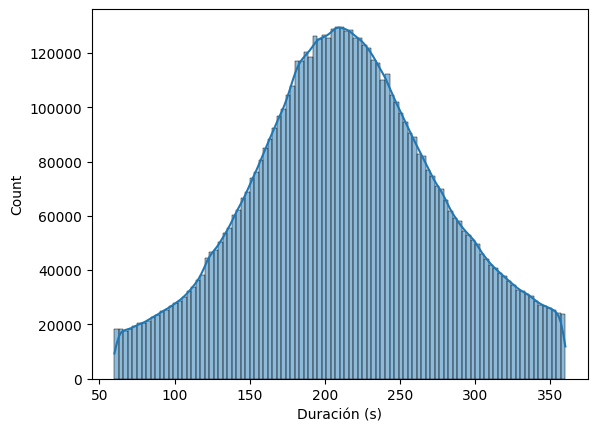

In [ ]:
merged_data['Duración (s)'] = merged_data['track_duration_ms'] / 1000
# histograma de la duracion de las canciones
sns.histplot(
  data = merged_data,
  x = 'Duración (s)',
  bins = 100,
  kde = True,
)
merged_data.drop(columns=['Duración (s)'], inplace=True)

<Axes: xlabel='track_popularity', ylabel='Count'>

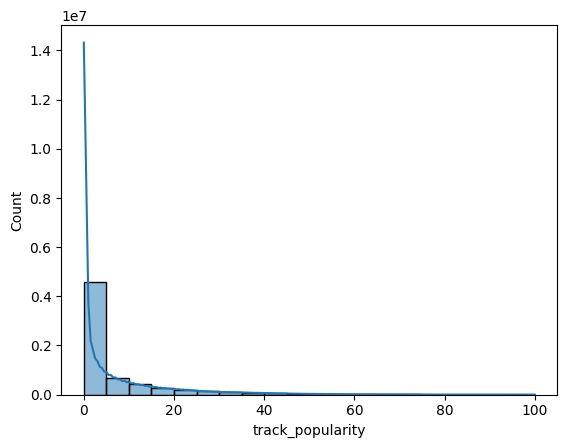

In [ ]:
sns.histplot(
  data = merged_data,
  x = 'track_popularity',
  bins = 20,
  kde = True,
)

<Axes: xlabel='album_release_date', ylabel='Count'>

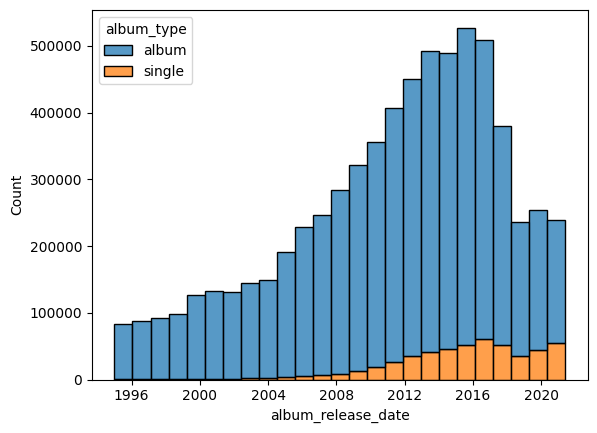

In [ ]:
# plot release date
sns.histplot(
  data = merged_data,
  x = 'album_release_date',
  bins = 25,
  hue='album_type',
  multiple='stack',
)

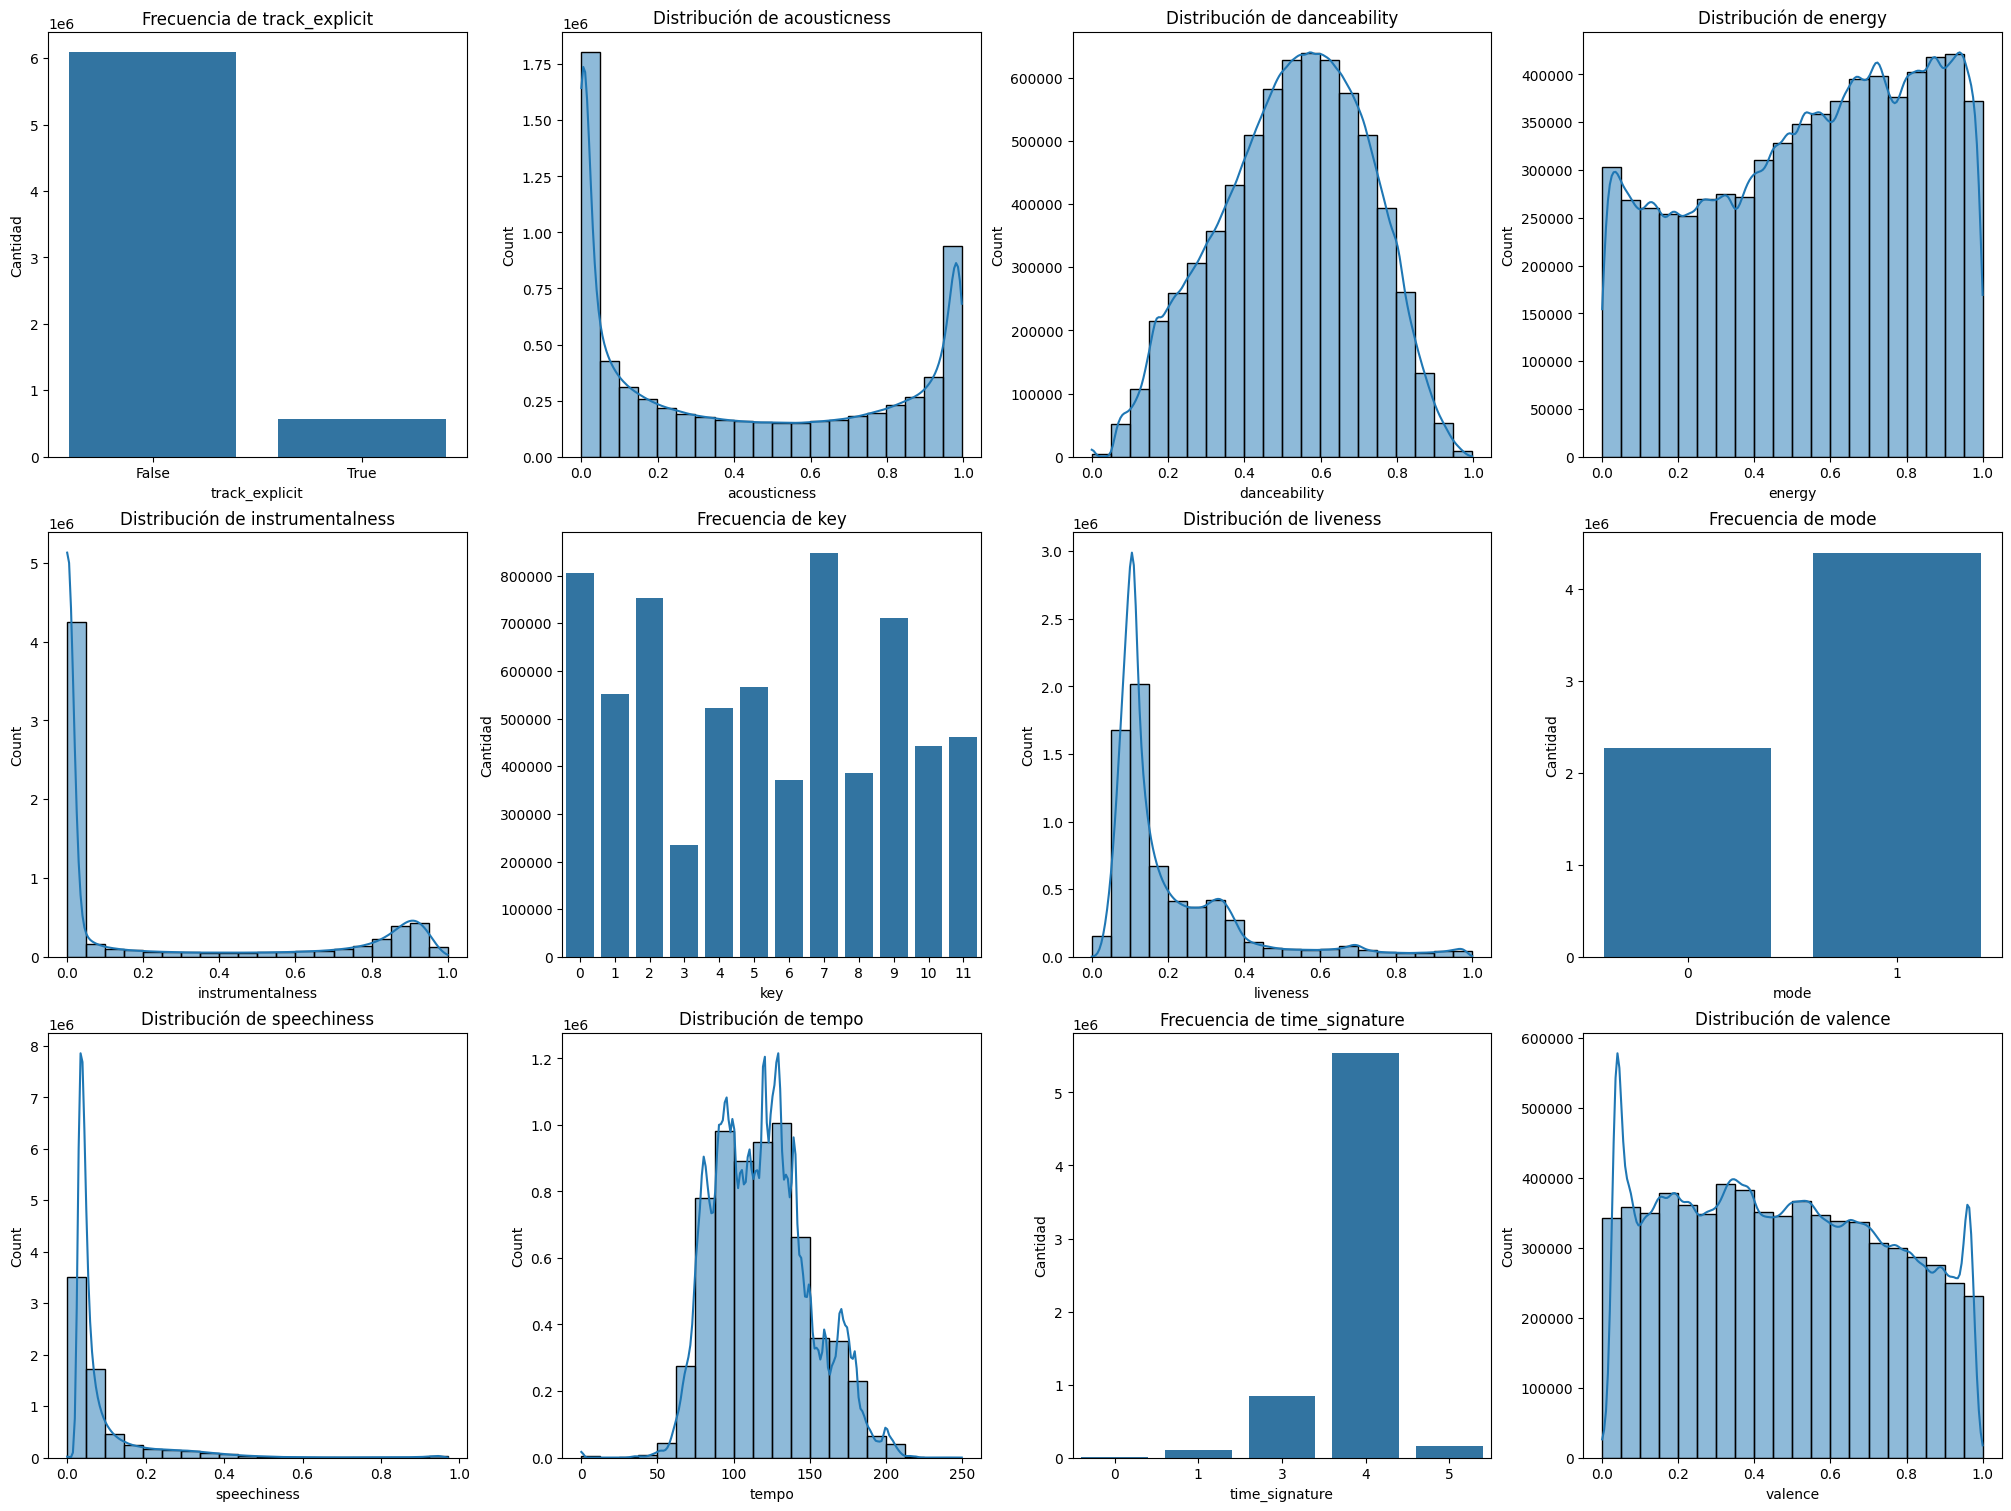

In [ ]:
plot_columns = {
  'track_explicit': 'discreta',
  'acousticness': 'continua',
  'danceability': 'continua',
  'energy': 'continua',
  'instrumentalness': 'continua',
  'key': 'discreta',
  'liveness': 'continua',
  'mode': 'discreta',
  'speechiness': 'continua',
  'tempo': 'continua',
  'time_signature': 'discreta',
  'valence': 'continua',
}
# plot multiples histogramas (12 columnas/features)
fig, axs = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)

for i, col in enumerate(plot_columns.keys()):
  if plot_columns[col] == 'continua':
    sns.histplot(
      data = merged_data,
      x = col,
      bins = 20,
      kde = True,
      ax = axs[i // 4, i % 4]
    )
    axs[i // 4, i % 4].set_title(f'Distribución de {col}')
  else:
    sns.countplot(
      data = merged_data,
      x = col,
      ax = axs[i // 4, i % 4]
    )
    axs[i // 4, i % 4].set_title(f'Frecuencia de {col}')
    axs[i // 4, i % 4].set_ylabel('Cantidad')

del plot_columns

# songs_normalize.csv

`songs_normalize.csv` es [un dataset de kaggle](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019) de los mejores hits de spotify, considerando desde 2000 al 2019.

## Descarga de datos

In [ ]:
# descargar el dataset si no existe
if not os.path.exists(data_folder + 'songs_normalize.csv'):
  !kaggle datasets download -d paradisejoy/top-hits-spotify-from-20002019 -p $data_folder --unzip

## Carga y modificaciones iniciales

In [ ]:
songs_normalize = pd.read_csv(
  filepath_or_buffer = data_folder + 'songs_normalize.csv',
).astype({
  'explicit': 'bool',
  'mode': 'category',
  'key': 'category',
})
songs_normalize.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.7510,0.8340,1,-5.4440,0,0.0437,0.3000,0.0000,0.3550,0.8940,95.0530,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.4340,0.8970,0,-4.9180,1,0.0488,0.0103,0.0000,0.6120,0.6840,148.7260,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.5290,0.4960,7,-9.0070,1,0.0290,0.1730,0.0000,0.2510,0.2780,136.8590,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.5510,0.9130,0,-4.0630,0,0.0466,0.0263,0.0000,0.3470,0.5440,119.9920,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.6140,0.9280,8,-4.8060,0,0.0516,0.0408,0.0010,0.0845,0.8790,172.6560,pop


In [ ]:
songs_normalize.shape

(2000, 18)

2000 filas y 18 columnas

In [ ]:
songs_normalize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   artist            2000 non-null   object  
 1   song              2000 non-null   object  
 2   duration_ms       2000 non-null   int64   
 3   explicit          2000 non-null   bool    
 4   year              2000 non-null   int64   
 5   popularity        2000 non-null   int64   
 6   danceability      2000 non-null   float64 
 7   energy            2000 non-null   float64 
 8   key               2000 non-null   category
 9   loudness          2000 non-null   float64 
 10  mode              2000 non-null   category
 11  speechiness       2000 non-null   float64 
 12  acousticness      2000 non-null   float64 
 13  instrumentalness  2000 non-null   float64 
 14  liveness          2000 non-null   float64 
 15  valence           2000 non-null   float64 
 16  tempo             2000 n

Podemos tratar un poco la columna `genre`, para que sea una lista de generos para cada cancion

In [ ]:
songs_normalize['genre'] = songs_normalize['genre'].apply(
  # split and then strip each genre
  lambda x: [i.strip() for i in x.split(',')]
)
songs_normalize['genre'].head()

0             [pop]
1       [rock, pop]
2    [pop, country]
3     [rock, metal]
4             [pop]
Name: genre, dtype: object

## Analisis y tratamiento de nulos

In [ ]:
print(f"=== Has NaN? ===")
for col in songs_normalize.columns:
  if col == 'genre':
    print(col, songs_normalize[col].apply(lambda x: len(x) == 0).any())
  else:
    print(col, songs_normalize[col].hasnans)

=== Has NaN? ===
artist False
song False
duration_ms False
explicit False
year False
popularity False
danceability False
energy False
key False
loudness False
mode False
speechiness False
acousticness False
instrumentalness False
liveness False
valence False
tempo False
genre False


## Analisis de columnas

In [ ]:
songs_normalize.describe()

,duration_ms,year,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000
mean,228748.1245,2009.4940,59.8725,0.6674,0.7204,-5.5124,0.1036,0.1290,0.0152,0.1812,0.5517,120.1226
std,39136.5690,5.8600,21.3356,0.1404,0.1527,1.9335,0.0962,0.1733,0.0878,0.1407,0.2209,26.9671
min,113000.0000,1998.0000,0.0000,0.1290,0.0549,-20.5140,0.0232,0.0000,0.0000,0.0215,0.0381,60.0190
25%,203580.0000,2004.0000,56.0000,0.5810,0.6220,-6.4902,0.0396,0.0140,0.0000,0.0881,0.3868,98.9857
50%,223279.5000,2010.0000,65.5000,0.6760,0.7360,-5.2850,0.0599,0.0557,0.0000,0.1240,0.5575,120.0215
75%,248133.0000,2015.0000,73.0000,0.7640,0.8390,-4.1677,0.1290,0.1762,0.0001,0.2410,0.7300,134.2655
max,484146.0000,2020.0000,89.0000,0.9750,0.9990,-0.2760,0.5760,0.9760,0.9850,0.8530,0.9730,210.8510


In [ ]:
songs_normalize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   artist            2000 non-null   object  
 1   song              2000 non-null   object  
 2   duration_ms       2000 non-null   int64   
 3   explicit          2000 non-null   bool    
 4   year              2000 non-null   int64   
 5   popularity        2000 non-null   int64   
 6   danceability      2000 non-null   float64 
 7   energy            2000 non-null   float64 
 8   key               2000 non-null   category
 9   loudness          2000 non-null   float64 
 10  mode              2000 non-null   category
 11  speechiness       2000 non-null   float64 
 12  acousticness      2000 non-null   float64 
 13  instrumentalness  2000 non-null   float64 
 14  liveness          2000 non-null   float64 
 15  valence           2000 non-null   float64 
 16  tempo             2000 n

In [ ]:
songs_normalize['explicit'].value_counts()

explicit
False    1449
True      551
Name: count, dtype: int64

In [ ]:
songs_normalize['year'].value_counts().sort_index()

year
1998      1
1999     38
2000     74
2001    108
2002     90
2003     97
2004     96
2005    104
2006     95
2007     94
2008     97
2009     84
2010    107
2011     99
2012    115
2013     89
2014    104
2015     99
2016     99
2017    111
2018    107
2019     89
2020      3
Name: count, dtype: int64

Tenemos un buen balance de canciones que salieron en los 2000 - 2019, pero fuera de ese rango faltaría una cantidad significativa de canciones.

In [ ]:
# obtain the genres
def get_genres(df):
  songs_normalize_genres = dict()
  for genre_list in songs_normalize['genre']:
    for genre in genre_list:
      if genre not in songs_normalize_genres:
        songs_normalize_genres[genre] = 0
      songs_normalize_genres[genre] += 1

  songs_normalize_genres = pd.DataFrame.from_dict(songs_normalize_genres, orient='index', columns=['count'])
  songs_normalize_genres.sort_values(by='count', ascending=False, inplace=True)
  return songs_normalize_genres

songs_normalize_genres = get_genres(songs_normalize)
songs_normalize_genres

,count
pop,1633
hip hop,778
R&B,452
Dance/Electronic,390
rock,234
metal,66
latin,64
set(),22
country,21
Folk/Acoustic,20


Hay un genero extraño entre ellos, `set()` parece haber sido un error, no lo consideraremos a partir de este punto.

In [ ]:
def remove_set_from_genres(genres):
  if 'set()' in genres:
    genres.remove('set()')
  return genres

songs_normalize['genre'] = songs_normalize['genre'].apply(remove_set_from_genres)

songs_normalize_genres = get_genres(songs_normalize)
songs_normalize_genres

,count
pop,1633
hip hop,778
R&B,452
Dance/Electronic,390
rock,234
metal,66
latin,64
country,21
Folk/Acoustic,20
World/Traditional,10


In [ ]:
songs_normalize_genres.shape

(14, 1)

Tenemos 14 generos

# Métodos Experimentales

## Regresión

Para responder la pregunta sobre si existe la posibilidad de predecir la popularidad de una canción en base a sus características, podemos plantear como solución, o respuesta, la técnica de Regresión. Con ella, podremos calcular el valor esperado de popularidad, con respecto a valores de los atributos, como por ejemplo “acousticness”. Para ello, consideraremos como los valores independientes a los atributos encontrados en “audio_features”, y el valor esperado “y”, corresponde a la popularidad.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6655031 entries, 0 to 6657302
Data columns (total 25 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   album_id               object        
 1   artist_id              object        
 2   track_id               object        
 3   track_duration_ms      int64         
 4   track_explicit         bool          
 5   audio_feature_id       object        
 6   track_name             object        
 7   track_number_in_album  int64         
 8   track_popularity       int64         
 9   album_name             object        
 10  album_type             category      
 11  album_release_date     datetime64[ns]
 12  artist_name            object        
 13  artist_followers       int64         
 14  acousticness           float64       
 15  danceability           float64       
 16  energy                 float64       
 17  instrumentalness       float64       
 18  key                    cate

Un coeficiente de determinación (R^2) cercano a 1 y un error cuadrático medio (MSE) bajo indican que el modelo es capaz de predecir la popularidad de las canciones en función de la característica que se esté estudiando. Si los resultados son prometedores, se puede considerar realizar predicciones en un conjunto de datos no visto para evaluar aún más el rendimiento de tu modelo.

### Regresión Lineal

In [ ]:
X_columns = [
  ['acousticness'],
  ['danceability'],
  ['track_duration_ms'],
  ['energy'],
  ['instrumentalness'],
  ['liveness'],
]
y = merged_data['track_popularity']

test_size = 0.2
random_state = 42
results = []

from typing import Union
def exec_linear_regression(df: pd.DataFrame, y: pd.Series, test_size: float, random_state: int, scaler = MinMaxScaler(), result_export_list: Union[list, None] = None):
  # Dividir los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=test_size, random_state=random_state)
  # Ajustar el scaler a los datos de entrenamiento
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  # Realiza predicciones con el modelo entrenado en los datos de prueba
  y_pred = LinearRegression().fit(X_train, y_train).predict(X_test)
  # Evalúa el rendimiento del modelo
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  print(f'----- {df.columns[0]} -----')
  print(f'R^2: {r2}')
  print(f'MSE: {mse} \n')
  if result_export_list is not None:
    result_export_list.append({
      'column': df.columns[0],
      'r2': r2,
      'mse': mse
    })
  return r2, mse

for cols in X_columns:
  exec_linear_regression(merged_data[cols], y, test_size, random_state, result_export_list=results)

print('------------------------')
promedio_r2 = 0.0
promedio_mse = 0.0
for result in results:
  promedio_r2 += result['r2']
  promedio_mse += result['mse']
promedio_r2 /= len(results)
promedio_mse /= len(results)

print(f'Promedio R^2: {promedio_r2}')
print(f'Promedio MSE: {promedio_mse}')

----- acousticness -----
R^2: 0.01005523897659355
MSE: 111.2441006426841 

----- danceability -----
R^2: 0.014466213851575871
MSE: 110.74842153790496 

----- track_duration_ms -----
R^2: 0.0005780947435800599
MSE: 112.30908570889393 

----- energy -----
R^2: 0.010565983868644047
MSE: 111.18670617138525 

----- instrumentalness -----
R^2: 0.01108618108423931
MSE: 111.12824950422142 

----- liveness -----
R^2: 4.156834209190219e-05
MSE: 112.36937735278617 

------------------------
Promedio R^2: 0.007798880144454123
Promedio MSE: 111.49765681964597


### Árboles

In [ ]:
X_columns = [
  ['acousticness'],
  ['danceability'],
  ['track_duration_ms'],
  ['energy'],
  ['instrumentalness'],
  ['liveness'],
]
y = merged_data['track_popularity']

test_size = 0.2
random_state = 42
results = []

def exec_decision_tree(df: pd.DataFrame, y: pd.Series, test_size: float, random_state: int, scaler = MinMaxScaler(), result_export_list: Union[list, None] = None):
  # Dividir los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=test_size, random_state=random_state)
  # Ajustar el scaler a los datos de entrenamiento
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  # Realiza predicciones con el modelo entrenado en los datos de prueba
  y_pred = DecisionTreeRegressor(random_state=random_state).fit(X_train, y_train).predict(X_test)
  # Evalúa el rendimiento del modelo
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  print(f'----- {df.columns[0]} -----')
  print(f'R^2: {r2}')
  print(f'MSE: {mse} \n')
  if result_export_list is not None:
    result_export_list.append({
      'column': df.columns[0],
      'r2': r2,
      'mse': mse
    })
  return r2, mse

for cols in X_columns:
  exec_decision_tree(merged_data[cols], y, test_size, random_state, result_export_list=results)

print('------------------------')
promedio_r2 = 0.0
promedio_mse = 0.0
for result in results:
  promedio_r2 += result['r2']
  promedio_mse += result['mse']
promedio_r2 /= len(results)
promedio_mse /= len(results)
print(f'Promedio R^2: {promedio_r2}')
print(f'Promedio MSE: {promedio_mse}')

----- acousticness -----
R^2: 0.018245969485214286
MSE: 110.32367509480187 

----- danceability -----
R^2: 0.014947629835956544
MSE: 110.69432287470069 

----- track_duration_ms -----
R^2: -0.029670648624951168
MSE: 115.70825946493751 

----- energy -----
R^2: 0.014711921927283877
MSE: 110.72081032667482 

----- instrumentalness -----
R^2: 0.017948376146256106
MSE: 110.3571168631238 

----- liveness -----
R^2: 0.00023031741460288746
MSE: 112.34816685534697 

------------------------
Promedio R^2: 0.006068927697393756
Promedio MSE: 111.69205857993096


### KNN

In [ ]:
X_columns = [
  ['acousticness'],
  ['danceability'],
  ['track_duration_ms'],
  ['energy'],
  ['instrumentalness'],
  ['liveness'],
]
y = merged_data['track_popularity']

test_size = 0.2
random_state = 42
k = 3  # Número de vecinos
results = []

def exec_knn(df: pd.DataFrame, y: pd.Series, test_size: float, random_state: int, k: int, scaler = MinMaxScaler(), result_export_list: Union[list, None] = None):
  # Dividir los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=test_size, random_state=random_state)
  # Ajustar el scaler a los datos de entrenamiento
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  # Realiza predicciones con el modelo entrenado en los datos de prueba
  y_pred = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train).predict(X_test)
  # Evalúa el rendimiento del modelo
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  print(f'----- {df.columns[0]} -----')
  print(f'R^2: {r2}')
  print(f'MSE: {mse} \n')
  if result_export_list is not None:
    result_export_list.append({
      'column': df.columns[0],
      'r2': r2,
      'mse': mse
    })
  return r2, mse

for cols in X_columns:
  exec_knn(merged_data[cols], y, test_size, random_state, k, result_export_list=results)

print('------------------------')
promedio_r2 = 0.0
promedio_mse = 0.0
for result in results:
  promedio_r2 += result['r2']
  promedio_mse += result['mse']
promedio_r2 /= len(results)
promedio_mse /= len(results)
print(f'Promedio R^2: {promedio_r2}')
print(f'Promedio MSE: {promedio_mse}')

----- acousticness -----
R^2: -0.31587020084297923
MSE: 147.86966184249974 

----- danceability -----
R^2: -0.32997969180088926
MSE: 149.45520246449985 

----- track_duration_ms -----
R^2: -0.2871089341174897
MSE: 144.63764185896676 

----- energy -----
R^2: -0.3511460376088802
MSE: 151.83375043607327 



### SVM

In [ ]:
X_columns = [
  ['acousticness'],
  ['danceability'],
  ['track_duration_ms'],
  ['energy'],
  ['instrumentalness'],
  ['liveness'],
]
y = merged_data['track_popularity']

test_size = 0.2
random_state = 42
results = []

# Crea y entrena un modelo de regresión SVM
model = SVR(kernel='linear')

def exec_svm(df: pd.DataFrame, y: pd.Series, test_size: float, random_state: int, scaler = MinMaxScaler(), result_export_list: Union[list, None] = None):
  # Dividir los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=test_size, random_state=random_state)
  # Ajustar el scaler a los datos de entrenamiento
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  # Realiza predicciones con el modelo entrenado en los datos de prueba
  y_pred = SVR(kernel='linear').fit(X_train, y_train).predict(X_test)
  # Evalúa el rendimiento del modelo
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  print(f'----- {df.columns[0]} -----')
  print(f'R^2: {r2}')
  print(f'MSE: {mse} \n')
  if result_export_list is not None:
    result_export_list.append({
      'column': df.columns[0],
      'r2': r2,
      'mse': mse
    })
  return r2, mse

for cols in X_columns:
  exec_svm(merged_data[cols], y, test_size, random_state, result_export_list=results)

print('------------------------')
promedio_r2 = 0.0
promedio_mse = 0.0
for result in results:
  promedio_r2 += result['r2']
  promedio_mse += result['mse']
promedio_r2 /= len(results)
promedio_mse /= len(results)
print(f'Promedio R^2: {promedio_r2}')
print(f'Promedio MSE: {promedio_mse}')


## Clustering

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sns

def get_pca(df: pd.DataFrame, columns: list, n_components=2):
  # Estandarizar los datos
  scaler = StandardScaler()
  df = scaler.fit_transform(df[columns])
  # Crear el objeto PCA y aplicarlo a los datos
  pca = PCA(n_components=n_components)
  pca.fit(df)
  # Obtener los componentes principales
  components = pca.transform(df)
  return components

def get_clusters(df: pd.DataFrame, n_clusters: int, random_state: int = 42):
  # Crear el objeto KMeans y entrenarlo
  kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10, max_iter=300)
  kmeans.fit(df)
  # Obtener las etiquetas de los clusters
  labels = kmeans.labels_
  # Obtener los centroides
  centroids = kmeans.cluster_centers_
  return labels, centroids

def get_closest(df: pd.DataFrame, centroids: np.ndarray):
  # Obtener los índices de los puntos más cercanos a los centroides
  closest = pairwise_distances_argmin_min(df, centroids)
  return closest


In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

pca = get_pca(songs_normalize, ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness'])
songs_normalize['PCA1'] = pca[:, 0]
songs_normalize['PCA2'] = pca[:, 1]

# k means determine k
distortions = []
inertias = []
K = range(1, 10)
for k in K:
  kmeanModel = KMeans(n_clusters=k, n_init=10).fit(pca)
  kmeanModel.fit(pca)
  distortions.append(sum(np.min(cdist(pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca.shape[0])
  inertias.append(kmeanModel.inertia_)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

X_Line = [K[0], K[-1]]
Y_Line = [distortions[0], distortions[-1]]

sns.lineplot(
  x = K,
  y = distortions,
  ax = ax[0],
)
sns.scatterplot(
  x = K,
  y = distortions,
  ax = ax[0],
)
sns.lineplot(
  x = X_Line,
  y = Y_Line,
  ax = ax[0],
  color = 'red',
  linestyle = '--',
)

ax[0].set_title('Elbow Method using Distortion')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Distortion')
ax[0].grid(True)

sns.lineplot(
  x = K,
  y = inertias,
  ax = ax[1],
)
sns.scatterplot(
  x = K,
  y = inertias,
  ax = ax[1],
)

ax[1].set_title('Elbow Method using Inertia')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Inertia')
ax[1].grid(True)



In [ ]:
k = 5
labels, centroids = get_clusters(pca, k)
songs_normalize['cluster'] = labels

closest = get_closest(pca, centroids)
songs_normalize

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
  data = songs_normalize,
  x = 'PCA1',
  y = 'PCA2',
  hue = 'cluster',
  palette = 'bright',
  alpha = 0.5,
  ax = ax,
)

In [ ]:
# plot de los clusters a traves de los años
years = songs_normalize['year'].unique()
years = np.sort(years)

fig = plt.figure(figsize=(20, 20), constrained_layout=True)
hue_order = np.sort(songs_normalize['cluster'].unique())
for i, year in enumerate(years):
  axs = fig.add_subplot(5, 5, i + 1)
  sns.scatterplot(
    data = songs_normalize[songs_normalize['year'] == year],
    x = 'PCA1',
    y = 'PCA2',
    hue = 'cluster',
    palette = 'bright',
    alpha = 0.5,
    hue_order = hue_order,
    ax = axs
  )
  axs.set_title(f'Clusters año {year}')
  axs.set_xlabel('PCA1')
  axs.set_ylabel('PCA2')
  axs.set_xlim(-5, 5)
  axs.set_ylim(-5, 5)

In [ ]:
from sklearn.cluster import DBSCAN


def get_dbscan(df: pd.DataFrame, eps: float, min_samples: int):
  # Crear el objeto DBSCAN y entrenarlo
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  dbscan.fit(df)
  # Obtener las etiquetas de los clusters
  labels = dbscan.labels_
  return labels

eps = 0.2
min_samples = 10
labels = get_dbscan(pca, eps, min_samples)
songs_normalize['DBSCAN_cluster'] = labels

# plot dbscan
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
  data = songs_normalize,
  x = 'PCA1',
  y = 'PCA2',
  hue = 'DBSCAN_cluster',
  palette = 'bright',
  alpha = 0.5,
  ax = ax,
)

ax.set_title(f'DBSCAN con eps={eps} y min_samples={min_samples}')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')

songs_normalize['DBSCAN_cluster'].value_counts()


Continuando con K-means

In [ ]:
# cancion mas popular de cada cluster
songs_normalize.sort_values(by='popularity', ascending=False).groupby('cluster').first()

In [ ]:
# canciones por cluster lineplot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(
  data = songs_normalize.groupby(['year', 'cluster']).count().reset_index(),
  x = 'year',
  y = 'popularity',
  hue = 'cluster',
  palette = 'bright',
  ax = ax,
  marker = 'o',
  hue_order=hue_order,
)

ax.set_title('Canciones por cluster a traves de los años')
ax.set_xlabel('Año')
ax.set_ylabel('Cantidad')
ax.set_xticks(years)
ax.grid(True)


### Popularidad promedio de los clusters por año

In [ ]:
# canciones por cluster lineplot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(
  data = songs_normalize.groupby(['year', 'cluster']).agg({'popularity': 'mean'}).reset_index(),
  x = 'year',
  y = 'popularity',
  hue = 'cluster',
  palette = 'bright',
  ax = ax,
  marker = 'o',
  hue_order=hue_order,
)

ax.set_title('Popularidad promedio por cluster a traves de los años')
ax.set_xlabel('Año')
ax.set_ylabel('Popularidad')
ax.set_xticks(years)
ax.set_yticks(np.arange(0, 110, 10))
ax.grid(True)

## Topic Modeling

In [22]:
import pandas as pd
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora


import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
lyrics = pd.read_csv(f'{data_folder}labeled_lyrics_cleaned.csv', index_col=0)
print(lyrics.shape)
lyrics

(158353, 4)


,artist,seq,song,label
0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r\nBut oh Lord, don't get me wrong\r\nI know a couple niggas that do\r\nI'm from a place where everybody knows your name\r\nThey say I gotta watch my attitude\r\nWhen they see money, man they all start actin' strange\r\nSo fuck with the ones that fuck with you\r\nThey can never say I'm brand new\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday\r\n\r\nI see all of these wanna-be hot R&B singers\r\nI swear you all sound the same\r\nThey start from the bottom, so far from the motto\r\nYou niggas'll never be Drake\r\nShout out to OVO\r\nMost of them prolly don't know me though\r\nI stay in the cut, I don't fuck with no\r\nBody but I D, that's a pun on No I.D\r\nWhen nobody know my name\r\nRunnin' for my dream wasn't hard to do\r\nYou break bread, I swear they all pull out a plate\r\nEat with the ones who starved with you\r\nIf I'm winnin' then my crew can't lose\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday\r\n\r\nI heard since you got money\r\nYou changed, you're actin' funny\r\nThat's why I gets on my lonely\r\nYou be lovin' when change is a hobby\r\nWho do you dress when you ain't got nobody?\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday",Everyday,0.6260
1,Elijah Blake,"The drinks go down and smoke goes up, I feel myself, got to let go\r\nMy cares get lost up in that crowd that go up, up and away yo\r\n\r\nSlow down the lights, eyes open wide\r\nWe live till we die, live till we die, live till we die\r\n\r\nAin't kill my vibe, don't blow my high, don't doubt that he from the band though\r\nI'm listening to this song, now I'm up up and away yo\r\n\r\nSlow down the lights, eyes open wide\r\nWe live till we die, live till we die, live till we die\r\nSlow down the lights, eyes open wide\r\nWe live till we die, live till we die, live till we die\r\nSlow down the lights, eyes open wide\r\nWe live till we die, live till we die, live till we die\r\n\r\nNights like this, I go all out, up so high, I can't come down\r\nLet me live just for right now\r\nYeah, yeah, bite me, I'm so gone\r\n\r\nHappier than a motherfucker, I can't feel my fa-ace\r\nNo squares in my circle, get up out my way\r\nHappier than a motherfucker, I can't feel my fa-ace\r\nWho you tryna dance? Get up out my way\r\nHappier than a motherfucker, I can't feel my fa-ace\r\nNo squares in my circle, get up out my way\r\nHappier than a motherfucker, I can't feel my fa-ace\r\nWho you tryna dance? Get up out my way\r\n\r\nWhen I'm out at night, I chase neon lights\r\nAll of my thoughts start to echo, yeah they start to echo\r\n\r\nSlow down the lights, eyes open wide\r\nWe live till we die, live till we die, live till we die\r\n\r\nSo I'ma roll the dice, and I hope that I\r\nDon't take more than I can handle, much than I can handle\r\n\r\nSlow down the lights, eyes open wide\r\nWe live till we die, live till we die, live till we die\r\nSlow down the lights, eyes open wide\r\nWe live till we die, live till we die, live till we die\r\nSlow down the lights, eyes open wide\r\nW

### Obtener las canciones populares

Buscaremos las canciones que esten presentes en `merged_data`

In [24]:
merge_df = merged_data[['track_name', 'artist_name', 'track_popularity', 'tempo', 'acousticness', 'danceability', 'instrumentalness', 'valence', 'track_explicit', 'track_duration_ms']]
merge_df.head()

,track_name,artist_name,track_popularity,tempo,acousticness,danceability,instrumentalness,valence,track_explicit,track_duration_ms
0,I Put A Spell On You,Screamin' Jay Hawkins,28,133.0850,0.3090,0.6010,0.0007,0.6750,False,208759
1,Portrait Of A Man,Screamin' Jay Hawkins,25,145.9490,0.5730,0.4460,0.0167,0.2780,False,254879
2,What's Gonna Happen On The 8th Day,Screamin' Jay Hawkins,4,114.6480,0.6410,0.5780,0.0000,0.5140,False,297879
3,We Love,Screamin' Jay Hawkins,3,174.1390,0.5720,0.3730,0.0000,0.4010,False,168519
4,Please Don't Leave Me,Screamin' Jay Hawkins,3,170.7830,0.2850,0.4210,0.0008,0.7570,False,226092


In [25]:
merge_df['track_name'] = merge_df['track_name'].str.lower()
merge_df['artist_name'] = merge_df['artist_name'].str.lower()
lyrics['song'] = lyrics['song'].str.lower()
lyrics['artist'] = lyrics['artist'].str.lower()

df = pd.merge(
  left = lyrics,
  right = merge_df,
  how = 'inner',
  left_on=['song', 'artist'],
  right_on=['track_name', 'artist_name']
).drop(columns=['song', 'artist'])
df

,seq,label,track_name,artist_name,track_popularity,tempo,acousticness,danceability,instrumentalness,valence,track_explicit,track_duration_ms
0,"No, no\r\nI ain't ever trapped out the bando\r\nBut oh Lord, don't get me wrong\r\nI know a couple niggas that do\r\nI'm from a place where everybody knows your name\r\nThey say I gotta watch my attitude\r\nWhen they see money, man they all start actin' strange\r\nSo fuck with the ones that fuck with you\r\nThey can never say I'm brand new\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday\r\n\r\nI see all of these wanna-be hot R&B singers\r\nI swear you all sound the same\r\nThey start from the bottom, so far from the motto\r\nYou niggas'll never be Drake\r\nShout out to OVO\r\nMost of them prolly don't know me though\r\nI stay in the cut, I don't fuck with no\r\nBody but I D, that's a pun on No I.D\r\nWhen nobody know my name\r\nRunnin' for my dream wasn't hard to do\r\nYou break bread, I swear they all pull out a plate\r\nEat with the ones who starved with you\r\nIf I'm winnin' then my crew can't lose\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday\r\n\r\nI heard since you got money\r\nYou changed, you're actin' funny\r\nThat's why I gets on my lonely\r\nYou be lovin' when change is a hobby\r\nWho do you dress when you ain't got nobody?\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday",0.6260,everyday,elijah blake,29,114.8970,0.3700,0.7830,0.0000,0.6340,True,331440
1,"No, no\r\nI ain't ever trapped out the bando\r\nBut oh Lord, don't get me wrong\r\nI know a couple niggas that do\r\nI'm from a place where everybody knows your name\r\nThey say I gotta watch my attitude\r\nWhen they see money, man they all start actin' strange\r\nSo fuck with the ones that fuck with you\r\nThey can never say I'm brand new\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday\r\n\r\nI see all of these wanna-be hot R&B singers\r\nI swear you all sound the same\r\nThey start from the bottom, so far from the motto\r\nYou niggas'll never be Drake\r\nShout out to OVO\r\nMost of them prolly don't know me though\r\nI stay in the cut, I don't fuck with no\r\nBody but I D, that's a pun on No I.D\r\nWhen nobody know my name\r\nRunnin' for my dream wasn't hard to do\r\nYou break bread, I swear they all pull out a plate\r\nEat with the ones who starved with you\r\nIf I'm winnin' then my crew can't lose\r\n\r\nIt's everyday, everyday\r\nEveryday, everyday, everyday\r\nEveryday, everyday\r\nEveryday, everyday\r\nI've been talkin' my shit, nigga that's regular\r\nI've been lovin' 'em thick, life is spectacular\r\nI spend like I'ma die rich, nigga I'm flexin', yeah\r\nEveryday, that's everyday\r\nThat's everyday\r\nThat's everyday\r\nThat's everyday, everyday\r\n\r\nI heard since you got money\r\nYou cha

In [26]:
df = df[df['track_popularity'] >= 70].reset_index(drop=True)
df.shape

(441, 12)

In [27]:
from nltk.corpus import stopwords
#clean the data
custom_stopwords = ['im', 'ive', 'oh', 'aint', 'dont', 'thats', 
               'em', 'ima', 'id', 'yo', 'u', 'ill', 'na', 
               'yeah', 'mi', 'di', 'la', 'dem', 'de', 'yuh', 
               'que', 'youre', 'shes', 'pum', 'cant', 'till', 
               'ya', 'uh', 'ah', 'da', 'e', 'el', 'te', 'tu', 
               'le', 'un', 'en', 'si', 'get', 'got', 'gonna',
                'gotta', 'wanna', 'wan', 'cause']
stopwords = stopwords.words('english')
stopwords.extend(custom_stopwords)

stop = set(stopwords)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    text = text.lower().replace('\r\n', ' ').replace('\n', ' ').replace('\r', ' ').replace('  ', ' ').strip()
    for punctuation in exclude:
        text = text.replace(punctuation, '')
    text = ' '.join([word for word in text.split() if word not in stop])
    text = ' '.join([word for word in text.split() if word not in custom_stopwords])
    text = ' '.join([lemma.lemmatize(word) for word in text.split()])
    return text.split()

In [28]:
df['text_clean']=df['seq'].apply(clean)
df

,seq,label,track_name,artist_name,track_popularity,tempo,acousticness,danceability,instrumentalness,valence,track_explicit,track_duration_ms,text_clean
0,"I'm jealous, I'm overzealous\r\nWhen I'm down, I get real down\r\nWhen I'm high, I don't come down\r\nI get angry, baby, believe me\r\nI could love you just like that\r\nAnd I could leave you just this fast\r\n\r\nBut you don't judge me\r\n'Cause if you did, baby, I would judge you too\r\nNo, you don't judge me\r\n'Cause if you did, baby, I would judge you too\r\n\r\n'Cause I got issues\r\nBut you got 'em too\r\nSo give 'em all to me\r\nAnd I'll give mine to you\r\nBask in the glory\r\nOf all our problems\r\n'Cause we got the kind of love\r\nIt takes to solve 'em\r\n\r\nYeah, I got issues\r\nAnd one of them is how bad I need you\r\n\r\nYou do shit on purpose\r\nYou get mad and you break things\r\nFeel bad, try to fix things\r\nBut you're perfect\r\nPoorly wired circuit\r\nAnd got hands like an ocean\r\nPush you out, pull you back in\r\n\r\n'Cause you don't judge me\r\n'Cause if you did, baby, I would judge you too\r\nNo, you don't judge me\r\n'Cause you see it from same point of view\r\n\r\n'Cause I got issues\r\nBut you got 'em too\r\nSo give 'em all to me\r\nAnd I'll give mine to you\r\nBask in the glory\r\nOf all our problems\r\n'Cause we got the kind of love\r\nIt takes to solve 'em\r\n\r\nYeah, I got issues\r\nAnd one of them is how bad I need you\r\n\r\n(I got issues, you got 'em too)\r\nAnd one of them is how bad I need you\r\n(I got issues, you got 'em too)\r\n\r\n'Cause I got issues\r\n(I got)\r\nBut you got 'em too\r\nSo give 'em all to me\r\n(You got 'em too)\r\nAnd I'll give mine to you\r\nBask in the glory\r\n(I got issues)\r\nOf all our problems\r\n'Cause we got the kind of love\r\n(You got 'em too)\r\nIt takes to solve 'em\r\n\r\nYeah, I got issues (I got)\r\nAnd one of them is how bad I need you (You got 'em too)\r\nYeah, I got issues (I got issues)\r\nAnd one of them is how bad I need you (You got 'em too)\r\nYeah, I got issues (I got)\r\nAnd one of them is how bad I need you",0.4550,issues,julia michaels,71,114.1450,0.4010,0.7280,0.0000,0.4550,False,176320,"[jealous, overzealous, real, high, come, angry, baby, believe, could, love, like, could, leave, fast, judge, baby, would, judge, judge, baby, would, judge, issue, give, give, mine, bask, glory, problem, kind, love, take, solve, issue, one, bad, need, shit, purpose, mad, break, thing, feel, bad, try, fix, thing, perfect, poorly, wired, circuit, hand, like, ocean, push, pull, back, judge, baby, would, judge, judge, see, point, view, issue, give, give, mine, bask, glory, problem, kind, love, take, solve, issue, one, bad, need, issue, one, bad, need, issue, issue, give, give, mine, bask, glory, issue, problem, kind, love, take, solve, issue, one, bad, ...]"
1,"There is a swelling storm\r\nAnd I'm caught up in the middle of it all\r\nAnd it takes control\r\nOf the person that I thought I was\r\nThe boy I used to know\r\n \r\nBut there, is a light\r\nIn the dark, and I feel its warmth\r\nIn my hands, and my heart\r\nWhy can't I hold on?\r\n \r\nIt comes and goes in waves\r\nIt always does, it always does\r\nWe watch as our young hearts fade\r\nInto the flood, into the flood\r\n \r\nThe freedom, of falling\r\nA feeling I thought was set in stone\r\nIt slips through, my fingers\r\nI'm trying hard to let go\r\nIt comes and goes in waves\r\nIt comes and goes in waves\r\nAnd carries us away\r\n \r\nThrough the wind\r\nDown to the place we used to lay when we were kids\r\nMemories, of a stolen place\r\nCaught in the silence \r\nAn echo lost in space\r\n \r\nIt comes and goes in waves\r\nIt always does, it always does\r\nWe watch as our young hearts fade\r\nInto the flood, into the flood\r\n \r\nThe freedom, of falling\r\nA feeling I thought was set in stone\r\nIt slips through, my fingers\r\nI'm trying hard to let go\r\nIt comes and goes in waves\r\nIt comes and goes in waves\r\nAnd carries us away\r\n \r\nI watched

In [29]:
long_string = df['text_clean'].str.join(', ')
long_string = long_string.str.cat(sep=', ')
long_string[:1000] # primeros 1000 caracteres de todas las palabras juntas

'jealous, overzealous, real, high, come, angry, baby, believe, could, love, like, could, leave, fast, judge, baby, would, judge, judge, baby, would, judge, issue, give, give, mine, bask, glory, problem, kind, love, take, solve, issue, one, bad, need, shit, purpose, mad, break, thing, feel, bad, try, fix, thing, perfect, poorly, wired, circuit, hand, like, ocean, push, pull, back, judge, baby, would, judge, judge, see, point, view, issue, give, give, mine, bask, glory, problem, kind, love, take, solve, issue, one, bad, need, issue, one, bad, need, issue, issue, give, give, mine, bask, glory, issue, problem, kind, love, take, solve, issue, one, bad, need, issue, issue, one, bad, need, issue, one, bad, need, swelling, storm, caught, middle, take, control, person, thought, boy, used, know, light, dark, feel, warmth, hand, heart, hold, come, go, wave, always, always, watch, young, heart, fade, flood, flood, freedom, falling, feeling, thought, set, stone, slip, finger, trying, hard, let, go,

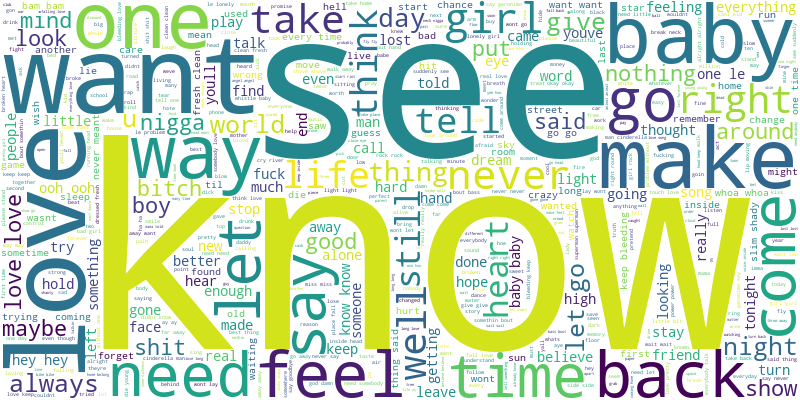

In [30]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

In [31]:
#create dictionary
dictionary = corpora.Dictionary(df['text_clean'])
#Total number of non-zeroes in the BOW matrix (sum of the number of unique words per document over the entire corpus).
print(dictionary.num_nnz)

34198


In [32]:
#create document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['text_clean'] ]
print(len(doc_term_matrix))

441


In [33]:
num_topics = 5
lda = LdaMulticore(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=30, workers=4, minimum_probability=0.01)
lda.print_topics(num_topics=num_topics)


[(0,
  '0.020*"love" + 0.019*"like" + 0.015*"want" + 0.015*"know" + 0.014*"go" + 0.011*"never" + 0.010*"let" + 0.008*"away" + 0.008*"baby" + 0.008*"back"'),
 (1,
  '0.031*"like" + 0.015*"girl" + 0.012*"baby" + 0.008*"still" + 0.008*"need" + 0.008*"shit" + 0.007*"go" + 0.007*"let" + 0.006*"take" + 0.006*"back"'),
 (2,
  '0.017*"know" + 0.013*"like" + 0.013*"one" + 0.012*"never" + 0.012*"see" + 0.010*"hey" + 0.009*"make" + 0.009*"way" + 0.009*"say" + 0.008*"go"'),
 (3,
  '0.014*"like" + 0.013*"go" + 0.009*"come" + 0.008*"right" + 0.008*"bout" + 0.008*"know" + 0.007*"rock" + 0.006*"could" + 0.006*"think" + 0.006*"time"'),
 (4,
  '0.033*"love" + 0.021*"know" + 0.016*"ooh" + 0.014*"baby" + 0.013*"one" + 0.012*"girl" + 0.010*"need" + 0.009*"time" + 0.009*"say" + 0.008*"feel"')]

In [34]:
#get the topic distribution for each document

def get_topic_distribution(lda_model, corpus):
    topic_distribution = []
    for i, row in enumerate(lda_model[corpus]):
        current_topic_distribution = [0 for _ in range(num_topics)]
        if len(row) == 0:
            print(f'row {i} is empty')
        for topic in row:
            current_topic_distribution[topic[0]] = topic[1]
        topic_distribution.append(current_topic_distribution)
        
    return topic_distribution

topic_distribution = get_topic_distribution(lda, doc_term_matrix)
topic_distribution = pd.DataFrame(topic_distribution)
topic_distribution.columns = ['topic_'+str(i) for i in range(num_topics)]
topic_distribution

#concatenate the topic distribution with the original dataframe
df = pd.concat([df, topic_distribution], axis=1)
df


,seq,label,track_name,artist_name,track_popularity,tempo,acousticness,danceability,instrumentalness,valence,track_explicit,track_duration_ms,text_clean,topic_0,topic_1,topic_2,topic_3,topic_4
0,"I'm jealous, I'm overzealous\r\nWhen I'm down, I get real down\r\nWhen I'm high, I don't come down\r\nI get angry, baby, believe me\r\nI could love you just like that\r\nAnd I could leave you just this fast\r\n\r\nBut you don't judge me\r\n'Cause if you did, baby, I would judge you too\r\nNo, you don't judge me\r\n'Cause if you did, baby, I would judge you too\r\n\r\n'Cause I got issues\r\nBut you got 'em too\r\nSo give 'em all to me\r\nAnd I'll give mine to you\r\nBask in the glory\r\nOf all our problems\r\n'Cause we got the kind of love\r\nIt takes to solve 'em\r\n\r\nYeah, I got issues\r\nAnd one of them is how bad I need you\r\n\r\nYou do shit on purpose\r\nYou get mad and you break things\r\nFeel bad, try to fix things\r\nBut you're perfect\r\nPoorly wired circuit\r\nAnd got hands like an ocean\r\nPush you out, pull you back in\r\n\r\n'Cause you don't judge me\r\n'Cause if you did, baby, I would judge you too\r\nNo, you don't judge me\r\n'Cause you see it from same point of view\r\n\r\n'Cause I got issues\r\nBut you got 'em too\r\nSo give 'em all to me\r\nAnd I'll give mine to you\r\nBask in the glory\r\nOf all our problems\r\n'Cause we got the kind of love\r\nIt takes to solve 'em\r\n\r\nYeah, I got issues\r\nAnd one of them is how bad I need you\r\n\r\n(I got issues, you got 'em too)\r\nAnd one of them is how bad I need you\r\n(I got issues, you got 'em too)\r\n\r\n'Cause I got issues\r\n(I got)\r\nBut you got 'em too\r\nSo give 'em all to me\r\n(You got 'em too)\r\nAnd I'll give mine to you\r\nBask in the glory\r\n(I got issues)\r\nOf all our problems\r\n'Cause we got the kind of love\r\n(You got 'em too)\r\nIt takes to solve 'em\r\n\r\nYeah, I got issues (I got)\r\nAnd one of them is how bad I need you (You got 'em too)\r\nYeah, I got issues (I got issues)\r\nAnd one of them is how bad I need you (You got 'em too)\r\nYeah, I got issues (I got)\r\nAnd one of them is how bad I need you",0.4550,issues,julia michaels,71,114.1450,0.4010,0.7280,0.0000,0.4550,False,176320,"[jealous, overzealous, real, high, come, angry, baby, believe, could, love, like, could, leave, fast, judge, baby, would, judge, judge, baby, would, judge, issue, give, give, mine, bask, glory, problem, kind, love, take, solve, issue, one, bad, need, shit, purpose, mad, break, thing, feel, bad, try, fix, thing, perfect, poorly, wired, circuit, hand, like, ocean, push, pull, back, judge, baby, would, judge, judge, see, point, view, issue, give, give, mine, bask, glory, problem, kind, love, take, solve, issue, one, bad, need, issue, one, bad, need, issue, issue, give, give, mine, bask, glory, issue, problem, kind, love, take, solve, issue, one, bad, ...]",0.0000,0.0000,0.0000,0.0000,0.9926
1,"There is a swelling storm\r\nAnd I'm caught up in the middle of it all\r\nAnd it takes control\r\nOf the person that I thought I was\r\nThe boy I used to know\r\n \r\nBut there, is a light\r\nIn the dark, and I feel its warmth\r\nIn my hands, and my heart\r\nWhy can't I hold on?\r\n \r\nIt comes and goes in waves\r\nIt always does, it always does\r\nWe watch as our young hearts fade\r\nInto the flood, into the flood\r\n \r\nThe freedom, of falling\r\nA feeling I thought was set in stone\r\nIt slips through, my fingers\r\nI'm trying hard to let go\r\nIt comes and goes in waves\r\nIt comes and goes in waves\r\nAnd carries us away\r\n \r\nThrough the wind\r\nDown to the place we used to lay when we were kids\r\nMemories, of a stolen place\r\nCaught in the silence \r\nAn echo lost in space\r\n \r\nIt comes and goes in waves\r\nIt always does, it always does\r\nWe watch as our young hearts fade\r\nInto the flood, into the flood\r\n \r\nThe freedom, of falling\r\nA feeling I thought was set in stone\r\nIt slips through, my fingers\r\nI'm trying hard to let go\r\nIt comes and goes in w

In [35]:
%pip install pyLDAvis==2.1.2

     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.6 MB 991.0 kB/s eta 0:00:02
     ------------ --------------------------- 0.5/1.6 MB 6.3 MB/s eta 0:00:01
     -------------------------- ------------- 1.1/1.6 MB 8.5 MB/s eta 0:00:01
     ---------------------------------------  1.6/1.6 MB 9.3 MB/s eta 0:00:01
     ---------------------------------------- 1.6/1.6 MB 9.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for wheel>=0.23.0 from https://files.pythonhosted.org/packages/c7/c3/55076fc728723ef927521abaa1955213d094933dc36d4a2008d5101e1af5/wheel-0.42.0-py3-none-any.whl.metadata
  U


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
vis = None
ENABLE_VIS = True
SAVE_VIS = True
if ENABLE_VIS:
  try:
    import pyLDAvis
    import pyLDAvis.gensim as gensimvis

    warnings.filterwarnings('ignore', category=DeprecationWarning)

    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda, doc_term_matrix, dictionary)
    if SAVE_VIS: pyLDAvis.save_html(vis, 'lda.html')
    
  except Exception as e:
    print(e)
    print(e.with_traceback())
    pass

vis

DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given


TypeError: BaseException.with_traceback() takes exactly one argument (0 given)